In [41]:
import numpy as np
import lightgbm as lgb
import os
import pandas as pd
import sklearn
from hyperopt import fmin, tpe, hp, partial, Trials, STATUS_OK
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, zero_one_loss
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
# import graphviz
# import shap
import lightgbm as lgb
import time
from math import sqrt
import re
import os
import math
import pickle
from sklearn.metrics import  zero_one_loss,mean_absolute_error,r2_score
from random import sample
import pylab as plt
from PyEMD import EMD

In [2]:
import sklearn
print(sklearn.__version__)

0.24.2


In [43]:
def CalGain(listL, listR, firstG, secondG, Lambda, gamma):
    """calculater Gain for histogram"""
    GL = firstG[listL].sum()
    GR = firstG[listR].sum()
    HL = secondG[listL].sum()
    HR = secondG[listR].sum()
    return (GL ** 2 / (HL + Lambda) + GR ** 2 / (HR + Lambda) - (GR + GL) ** 2 / (
                HL + HR + Lambda)) / 2 - gamma

def getListMaxNumIndex(num_list,topk=3):
    num_dict={}
    for i in range(len(num_list)):
        num_dict[i]=num_list[i]
    res_list=sorted(num_dict.items(),key=lambda e:e[1])
    max_num_index=[one[0] for one in res_list[::-1][:topk]]
    #min_num_index=[one[0] for one in res_list[:topk]]
    #print ('max_num_index:',max_num_index)
    #print ('min_num_index:',min_num_index)
    return max_num_index

def find_split_worker(x_train, g, h, indexlist, k,bins, Lambda, gamma):
    topKsplit = []
    topKgain = []
    firstG = g[indexlist]
    secondG = h[indexlist]
    for feature in range(x_train.shape[1]):
        bestGain = 0
        bestSplitValue = -1
        AllValue = sorted(set(x_train[:, feature]))
        if len(AllValue) > bins:
            try:
                ValueSet = sample(AllValue, bins)
            except:
                print("length of Allvalue is :", len(AllValue))
                print("length of self.bins is :", bins)
        else:
            ValueSet = AllValue
        for Val in ValueSet:
            boolindexLeft = x_train[:, feature] <= Val
            boolindexRight = ~boolindexLeft
            indexLeft = boolindexLeft
            indexRight = boolindexRight

            gain = CalGain(indexLeft, indexRight, firstG, secondG, Lambda, gamma)
            if gain > bestGain:
                bestGain = gain
                bestSplitValue = Val
        topKsplit.append({feature: bestSplitValue})
        topKgain.append(bestGain)
    index = getListMaxNumIndex(topKgain, topk=k)
    topgainList = []
    topsplitList = []
    for i in index:
        topgainList.append(topKgain[i])
        topsplitList.append(topKsplit[i])
    return topgainList, topsplitList

def EMDpreprocess(dataframe):    
    np_array=np.array(dataframe)
    #inputs=client.compute(x[:,0], worker=worker[0])
#     #inputs=client.compute(x[:,0])
    inputs, targets=np_array[:, 0], np_array[:, 1]
    t=np.array([i for i in range(len(inputs))])
    #IMF = EMD().emd(inputs, max_imf=2)
    #N = IMF.shape[0]+1
    windowsize=19
    offset = int(0.5 * (windowsize - 1.0))
    window_num=inputs.size - 2 * offset
#     IMF=IMF.transpose()
#     print(IMF.shape)
    features=list()
    labels=list()
    for i in range(0,window_num):
        #inp=inputs[i:i+windowsize,:]
        data_in=inputs[i:i+windowsize]
        tar=targets[i+offset]
        #data_in=np.hstack(inp)
        features.append(data_in)
        labels.append(tar)
    X=np.array(features)
    Y=np.array(labels)
    x_train_all, x_predict, y_train_all, y_predict = train_test_split(X, Y, test_size=0.2,random_state=100)
    x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size=0.2,random_state=100)
    return  x_train_all, y_train_all, x_predict, y_predict, x_test,  y_test


def getDataTrans(workers, treecount, outlog, treenum):
    string1='find_split_worker'
    string2='getHistog'
#     treecount=[treecount1,treecount2,treecount3]
    print('treecount is:', treecount)
    volumn=[]
    for j in range(len(workers)):
        localcount=0
        globalcount=0
        index=treecount[j]
        treecount[j]=len(outlog[workers[j]])
        for i in range(index, treecount[j]):
                if string1 in str(outlog[workers[j]][i]['keys'].keys()):
                    localcount+=int(outlog[workers[j]][i]['total'])
                elif string2 in str(outlog[workers[j]][i]['keys'].keys()):
                    globalcount+=int(outlog[workers[j]][i]['total'])
                else:
                    continue
        print("worker data: ", j)
        print("Find split in workers is :", localcount)
        print("total higtograms transferred is :",globalcount)
        volumn.append([treenum,'runner'+str(j),localcount+globalcount])
    print("transfer treecount is", treecount)
    return treecount, volumn

In [40]:
a=[]
a.append([1,"worker2",3,4])
a.append([2,"dsffds",4,5])
np.array(a)
b=[]
a+b

[[1, 'worker2', 3, 4], [2, 'dsffds', 4, 5]]

In [60]:
#all method/task executed by workers
def getPara(future,i):
    return future[i]

def getData(future,i):
    return future[i]

def getHistog(x_train, firstg, secondg, indexlist, flist):
    x=x_train
    g=firstg[indexlist]
    h=secondg[indexlist]
    histograms=[]
    for feature in flist:
        histg, edges1=np.histogram(x[:,feature], bins=200, weights=g)
        histh, edges2=np.histogram(x[:,feature], bins=200, weights=h)
        histograms.append((histg,histh))
    return histograms


def inithaty(dataSample):
    haty = np.zeros(len(dataSample))
    return haty
#initialise the value of second-order gradients    
def inith(dataSample):
    h = np.ones(len(dataSample)) * 2
    return h
#calculate first-order gradients of samples located at any certain worker   
def calG(y_train, haty):
    """calculate g_i"""
    return -2 * (y_train - haty)

def initf(x_train):
    return np.empty(len(x_train))

def initindex(x_train):
    return np.arange(x_train.shape[0])

#calculate f of current tree
def assignf(indexlist, f, w):
    f[indexlist]=w
    return True

def newNode(x_train, y_train, indexlist, bestSplitFeature, bestSplitValue):
    left_index = x_train[:, bestSplitFeature] <= bestSplitValue
    sub_X_train_left, sub_y_train_left = x_train[left_index], y_train[left_index]
    sub_X_train_right, sub_y_train_right = x_train[~left_index], y_train[~left_index]
    indexlist_left = indexlist[left_index]
    indexlist_right = indexlist[~left_index]
    return sub_X_train_left, sub_y_train_left, sub_X_train_right, sub_y_train_right, indexlist_left, indexlist_right

#update the value of prediction output at current stage
def updateHaty(haty, f, eta):
    updateHaty=haty + eta * f
    return updateHaty

def test(a,b,i):
    return a+b*i

def getLoss_worker(y_train, haty):
#     return mean_absolute_error(y_train, haty)
    return mean_squared_error(y_train, haty, squared=False)

In [62]:
from dask.distributed import wait
class DaskBooster():
    def __init__(self, k, workers, client=None, num_round=50, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae", maxbins=500, maxdepth=10):
        #self.filePath=filePath
        self.client=client
        self.scoring = scoring
        self.num_round = num_round
        self.eta = eta
        self.gamma = gamma
        self.Lambda = Lambda
        self.ensemble = []
        self.firstG= None #first order gradient
        self.secondG = None #second order gradient
        self.haty = None
        self.f = None
        self.indexList=None
        self.workers=workers
        self.bins= maxbins
        self.trace=[]
        self.k=k
        self.depth=maxdepth
        self.worker_trace=[]
        self.volumn=[]
        
    def getLoss(self, y_train):
        haty=self.client.gather(self.haty)
        y=self.client.gather(y_train)
        haty=np.concatenate(haty, axis=0)
        y=np.concatenate(y, axis=0)
        return mean_squared_error(y, haty, squared=False), mean_absolute_error(y, haty)
    
    def _G(self, y_train, haty):
        """calculate g_i"""
        return -2 * (y_train - haty)

    def _Gain(self, listL, listR, firstG, secondG):
        """calculater Gain for histogram"""

        GL = firstG[listL].sum()
        GR = firstG[listR].sum()
        HL = secondG[listL].sum()
        HR = secondG[listR].sum()

        return (GL ** 2 / (HL + self.Lambda) + GR ** 2 / (HR + self.Lambda) - (GR + GL) ** 2 / (
                    HL + HR + self.Lambda)) / 2 - self.gamma

    def _w(self, indexlist):
#         return -np.sum(self.g[indexlist]) / (np.sum(self.h[indexlist]) + self.Lambda)
        first=self.client.gather(self.firstG)
        second=self.client.gather(self.secondG)
        indexlist=self.client.gather(indexlist)
        #wait(first)
        #wait(second)
        sumG=0
        sumH=0
        for i in range(len(first)):
            sumG+=np.sum(first[i][indexlist[i]])
            sumH+=np.sum(second[i][indexlist[i]])
        return -sumG/ (sumH+self.Lambda)
        

#     def calWeight(indexlist, firstG, secondG):
#         Lambda=0.7145
#         return -np.sum(firstG[indexlist]) / (np.sum(secondG[indexlist]) + Lambda)

    def BestSplit(self, x_train, indexlist):
            bestGain = 0
            bestSplitFeature= -1
            bestSplitValue=-1
            #print(len(X_train))
            x_train_worker=x_train
            x_all_set=self.client.gather(x_train)
            x_train=np.concatenate(x_all_set, axis=0)
            firstG=[]
            secondG=[]
            indexlist=self.client.gather(indexlist) 
            g=self.client.gather(self.firstG)

            
            for i in range(len(g)):
#                 print(g[i].shape)
#                 print(indexlist[i].shape)
                firstG.append(g[i][indexlist[i]])
            #print(firstG)
            #print(len(firstG))
            firstG=np.concatenate(firstG, axis=0)
            #print('d dggg',firstG.shape)
            h=self.client.gather(self.secondG)

            for i in range(len(h)):
                secondG.append(h[i][indexlist[i]])
            secondG=np.concatenate(secondG, axis=0)
            splitCandidates=[]
            for i in range(len(indexlist)):
                splitCandidates.append(self.client.submit(find_split_worker,x_train_worker[i], self.firstG[i], self.secondG[i], indexlist[i],  self.k, self.bins, self.Lambda, self.gamma, workers=self.workers[i])) 
            wait(splitCandidates)
            #print("split candidates is as follows: \n", splitCandidates)
            splitCandidates=self.client.gather(splitCandidates)
            candidates=list()
            "Derive topK candidates from feature list"

            for element in splitCandidates:
                for feature in element[1]:
                    candidates.append(list(feature.keys())[0])
            candidates=np.array(candidates)
            candiset, cnt = np.unique(candidates, return_counts=True)
                #candiset=candiset.tolist()
            cnt=cnt.tolist()
            max_num_index=getListMaxNumIndex(cnt, topk=self.k)
            #print("max number of index is:", max_num_index)
            histograms=[]
            for i in range(len(indexlist)):
                histograms.append(self.client.submit(getHistog,x_train_worker[i], self.firstG[i], self.secondG[i], indexlist[i], candiset[max_num_index],workers=self.workers[i]))
            wait(histograms)
            histograms=self.client.gather(histograms)   
            for feature in candiset[max_num_index]:
                    #print(feature)
                AllValue = sorted(set(x_train[:, feature]))
                if len(AllValue) > self.bins:
                    try:
                        ValueSet = sample(AllValue, self.bins)
                    except:
                        print("length of Allvalue is :", len(AllValue))
                        print("length of self.bins is :", self.bins)
                else:
                    ValueSet = AllValue
                for Val in ValueSet:
                    #print("value is:", Val)
                    #print(x_train[:, feature].shape)
                    boolindexLeft = x_train[:, feature] <= Val
                    boolindexRight = ~boolindexLeft
                    indexLeft=boolindexLeft
                    indexRight=boolindexRight
                    #print('left is:', firstG[indexLeft].shape)
                    #print('right index is',firstG[indexRight].shape)
                    gain = self._Gain(indexLeft, indexRight, firstG, secondG)

                    if gain > bestGain:
                        bestGain = gain
                        bestSplitFeature=feature
                        bestSplitValue = Val
            if bestSplitFeature==-1:
                return None, None
            else:
                return bestSplitFeature, bestSplitValue


    def create_tree(self, x_train, y_train, depth, indexlists):
            bestSplitFeature, bestSplitValue = self.BestSplit(x_train, indexlists)  
            numSample=0
            for indexlist in indexlists:
                numSample+=indexlist.result().shape[0]
            if (bestSplitFeature is None or numSample<200 or depth>self.depth):
                w = self._w(indexlists)
                allweight=[]
                for i in range(len(indexlists)):
                    curf=self.client.submit(assignf, indexlists[i], self.f[i], w, workers=self.workers[i])
                    allweight.append(curf)
                wait(allweight)
                return w
            else:
                depth+=1
                sub_X_train_left, sub_y_train_left, sub_X_train_right, sub_y_train_right, indexlist_left, indexlist_right=[],[],[],[],[],[]
                childPara=[]
                for i in range(len(indexlists)):
                    #X_train_left, y_train_left, X_train_right, y_train_right, leftindex, rightindex=client.submit(newNode, x_train[i], y_train[i], indexlist[i], bestSplitFeature, bestSplitValue)
                    childPara.append(self.client.submit(newNode, x_train[i], y_train[i], indexlists[i], bestSplitFeature, bestSplitValue, workers=self.workers[i]))
                wait(childPara)
                i=0
                for child in childPara:
                    X_train_left=self.client.submit(getPara, child, 0, workers=self.workers[i])
                    y_train_left=self.client.submit(getPara, child, 1, workers=self.workers[i])
                    X_train_right=self.client.submit(getPara, child, 2, workers=self.workers[i])
                    y_train_right=self.client.submit(getPara, child, 3, workers=self.workers[i])
                    leftindex=self.client.submit(getPara, child, 4, workers=self.workers[i])
                    rightindex=self.client.submit(getPara, child, 5, workers=self.workers[i])
                    sub_X_train_left.append(X_train_left)
                    sub_y_train_left.append(y_train_left)
                    sub_X_train_right.append(X_train_right)
                    sub_y_train_right.append(y_train_right)
                    indexlist_left.append(leftindex)
                    indexlist_right.append(rightindex)
                    i+=1
                wait(sub_X_train_left)
                wait(sub_y_train_left)
                wait(sub_X_train_right)
                wait(sub_y_train_right)
                wait(indexlist_left)
                wait(indexlist_right)

                leftchild = self.create_tree(sub_X_train_left, sub_y_train_left, depth, indexlist_left)
                rightchild = self.create_tree(sub_X_train_right, sub_y_train_right, depth, indexlist_right)
                return {bestSplitFeature: {"<={}".format(bestSplitValue): leftchild,
                                            ">{}".format(bestSplitValue): rightchild}}
        
    
    def fit(self, fileList):
        x_train, y_train, x_test, y_test, x_valid, y_valid=[],[],[],[],[],[]  
        data_frames=[]
        for i in range(len(fileList)):
            data_frame=pd.read_csv(fileList[i],header=0)            
            data_frames.append(data_frame)             
            
        allData=client.map(EMDpreprocess,data_frames, workers=self.workers)
        wait(allData)
        x_train=client.map(getData,allData, [0,0,0], workers=self.workers)
        y_train=client.map(getData,allData,[1,1,1], workers=self.workers)
        wait(x_train)
        wait(y_train)
        self.haty=[]
        self.secondG=[]
        #self.firstG=[]
        self.indexLists=[]
        allworkers=[]
        for k in range(len(self.workers)):
            allworkers.append('tcp://'+ self.workers[k])
        for i in range(len(fileList)):
            weight=self.client.submit(inithaty, x_train[i], workers=self.workers[i])
            self.haty.append(weight)
        wait(self.haty)
        
        for i in range(len(fileList)):
            hess=self.client.submit(inith, x_train[i], workers=self.workers[i])
            self.secondG.append(hess) 
        wait(self.secondG)
        
#         results=self.client.gather(x_train)
#         for result in results:
#             self.indexList.append(np.arange(result.size))
        for i in range(len(fileList)):           
            indexlist=self.client.submit(initindex, x_train[i], workers=self.workers[i])
            self.indexLists.append(indexlist) 
        wait(self.indexLists)
        
#         for i in range(len(fileList)):
#             workTrace=[]
#             self.worker_trace.append(workTrace)
        treecount=[]
        for k in range(len(self.workers)):
            treecount.append(0)

        for index in range(self.num_round):            
            self.firstG=[]
            self.f=[]
            print('start the tree0: ', index)
            for i in range(len(fileList)):
                grad=self.client.submit(calG, y_train[i], self.haty[i], workers=self.workers[i])
                self.firstG.append(grad)
            wait(self.firstG)

            for i in range(len(fileList)):
                currentf=self.client.submit(initf, x_train[i], workers=self.workers[i])
                self.f.append(currentf)
            wait(self.f)
            if index==0:
                loss, mae =self.getLoss(y_train)
                self.trace.append(loss)
                print("initail mae is:", mae)
                print("initail loss is:", loss)
                currentLoss=[]
                for i in range(len(fileList)):
                    currentLoss.append(self.client.submit(getLoss_worker, y_train[i], self.haty[i], workers=self.workers[i]))
                wait(currentLoss)
                self.worker_trace.append(self.client.gather(currentLoss))
                    
            newtree = self.create_tree(x_train, y_train, 0, self.indexLists)
            newhaty=[]
            for i in range(len(fileList)):
                #print(self.client.gather(self.f)[i][:5])
                a=self.client.submit(updateHaty, self.haty[i],self.f[i], self.eta, workers=self.workers[i])
                #print(a.result())
                newhaty.append(a)            
            wait(newhaty)
            self.haty=newhaty
            #print("haty is:", self.client.gather(self.haty)[0][:5])

            currentLoss=[]
            for i in range(len(fileList)):
                currentLoss.append(self.client.submit(getLoss_worker, y_train[i], self.haty[i], workers=self.workers[i]))
            wait(currentLoss)
            self.worker_trace.append(self.client.gather(currentLoss))
            loss, mae=self.getLoss(y_train)
            print("converage loss is:", loss)
            print("mae in this step is", mae)
            self.trace.append(loss)
            self.ensemble.append(newtree)
            outlog=client.run(lambda dask_worker: dask_worker.outgoing_transfer_log)
            treecount,volumn=getDataTrans(allworkers, treecount, outlog, index)
            self.volumn=self.volumn+volumn
        f = open("F:/NILM/test/modelt1.txt", 'w')
        f.write(str(self.ensemble))
        f.close()
        print(self.volumn)
        return
        



    def draw_one_tree(self, index):
        from graphviz import Digraph
        def export_graphviz(tree, root_index):
            root = next(iter(tree))
            text_node.append([str(root_index), "feature:{}".format(root)])
            secondDic = tree[root]
            for key in secondDic:
                if type(secondDic[key]) == dict:
                    i[0] += 1
                    secondrootindex = i[0]
                    text_edge.append([str(root_index), str(secondrootindex), str(key)])
                    export_graphviz(secondDic[key], secondrootindex)
                else:
                    i[0] += 1
                    text_node.append([str(i[0]), str(secondDic[key])])
                    text_edge.append([str(root_index), str(i[0]), str(key)])

        tree = self.ensemble[index]
        text_node = []
        text_edge = []
        i = [1]
        export_graphviz(tree, i[0])
        dot = Digraph()
        for line in text_node:
            dot.node(line[0], line[1])
        for line in text_edge:
            dot.edge(line[0], line[1], line[2])

        dot.view()

    def predict(self, X_test):
        return np.array([self._predict(test) for test in X_test])

    def _predict(self, test):

        def __predict(tree, test):
            feature = next(iter(tree))
            secondDic = tree[feature]
            content = test[feature]
            for key in secondDic:
                if eval(str(content) + key):
                    if type(secondDic[key]) == dict:
                        return __predict(secondDic[key], test)
                    else:
                        return secondDic[key]

        assert len(self.ensemble) != 0, "fit before predict"
        res = 0
        for i in range(len(self.ensemble)):
            tree = self.ensemble[i]
            res_temp = __predict(tree, test)
            res += res_temp * self.eta
        return res

    def score(self, X_test, y_test):
        y_pre = self.predict(X_test)
        if self.scoring == "mse":
            return sum((y_test - y_pre) ** 2) / len(X_test)
        elif self.scoring == "r2":
            return 1 - sum((y_test - y_pre) ** 2) / sum((y_test - y_test.mean()) ** 2)

    def get_params(self, deep=False):
        dic = {}
        dic["num_round"] = self.num_round
        dic["eta"] = self.eta
        dic["gamma"] = self.gamma
        dic["Lambda"] = self.Lambda
        dic["scoring"] = self.scoring
        return dic
    
    def testlog(self,fileList):
        x_train, y_train, x_test, y_test, x_valid, y_valid=[],[],[],[],[],[]  
        data_frames=[]
        for i in range(len(fileList)):
            data_frame=pd.read_csv(fileList[i],header=0)            
            data_frames.append(data_frame)             
            
        allData=client.map(EMDpreprocess,data_frames, workers=self.workers)
        wait(allData)
        x_train=client.map(getData,allData, [0,0,0], workers=self.workers)
        y_train=client.map(getData,allData,[1,1,1], workers=self.workers)
        wait(x_train)
        wait(y_train)
        print(type(x_train[0]))
        x_all_set=self.client.gather(x_train)
        x_train=np.concatenate(x_all_set, axis=0)
        
#         self.haty=[]
#         for i in range(len(fileList)):
#             weight=self.client.submit(inithaty, x_train[i], workers=self.workers[i])
#             self.haty.append(weight)
#         wait(self.haty)
        


In [44]:
from dask import delayed, is_dask_collection
from dask.distributed import default_client, wait
from dask.distributed import Client
client = Client()  # connect to cluster
client

c:\users\chang\appdata\local\programs\python\python37\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58074 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:58077 Dashboard: http://127.0.0.1:58074/status,Cluster Workers: 3 Cores: 6 Memory: 17.11 GB


In [115]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=3)
client = Client(cluster)
client

c:\users\chang\appdata\local\programs\python\python37\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57112 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:57115 Dashboard: http://127.0.0.1:57112/status,Cluster Workers: 3 Cores: 6 Memory: 17.11 GB


In [114]:
client.close()

In [119]:
# workers=[worker0,worker1,worker2,worker3,worker4,worker5,worker6]
worker0="127.0.0.1:53898"
worker1="127.0.0.1:53895"
worker2="127.0.0.1:53892"
# worker3="127.0.0.1:52758"
# worker4="127.0.0.1:52764"
# worker5="127.0.0.1:54327"

workers=[worker0,worker1,worker2]
# workers=[worker0,worker1,worker2, worker3, worker4]
booster0=DaskBooster(6, workers, client=client, num_round=20, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=200, maxdepth=10)
trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
trainfile0="F:/NILM/training_data/dishwasher_test_.csv"
# trainfile1="F:/NILM/refit_training/dishwasher/dishwasher_house_13_training_.csv"
# trainfile2="F:/NILM/refit_training/dishwasher/dishwasher_house_16_training_.csv"
# trainfile3="F:/NILM/refit_training/dishwasher/dishwasher_house_18_training_.csv"
# trainfile4="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_20_training_.csv"
# trainfile5="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_5_training_.csv"
# trainfile6="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_7_training_.csv"
# trainfile7="/home/ubuntu/NILM/refit_training/dishwasher/dishwasher_house_9_training_.csv"
         
# trainfile1="F:/NILM/refit_training/microwave/microwave_house_4_training_.csv"
# trainfile2="F:/NILM/refit_training/microwave/microwave_house_10_training_.csv"
# trainfile3="F:/NILM/refit_training/microwave/microwave_house_12_training_.csv"
# trainfile4="F:/NILM/refit_training/microwave/microwave_house_17_training_.csv"
# # trainfile5="F:/NILM/refit_training/microwave/microwave_house_19_training_.csv"         


#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"
fileList=[trainfile0, trainfile1, trainfile2]
# fileList=[trainfile1, trainfile2, trainfile3,trainfile4, trainfile5]
#fileList=[trainfile1, trainfile2,trainfile3, trainfile4,trainfile5, trainfile6,trainfile7]
booster0.fit(fileList)

KeyboardInterrupt: 

In [63]:
# workers=[worker0,worker1,worker2,worker3,worker4,worker5,worker6]
worker0="127.0.0.1:59503"
worker1="127.0.0.1:59500"
worker2="127.0.0.1:59497"
# worker3="127.0.0.1:52758"
# worker4="127.0.0.1:52764"
# worker5="127.0.0.1:54327"
trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
trainfile0="F:/NILM/training_data/dishwasher_test_.csv"
workers=[worker0,worker1,worker2]
fileList=[trainfile0, trainfile1, trainfile2]
booster0=DaskBooster(6, workers, client=client, num_round=10, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=100, maxdepth=5)
booster0.fit(fileList)

start the tree0:  0
initail mae is: 14.51770957475038
initail loss is: 113.40934248210662
converage loss is: 97.39546666155572
mae in this step is 14.009546389705596
treecount is: [0, 0, 0]
worker data:  0
Find split in workers is : 25596560
total higtograms transferred is : 187717376
worker data:  1
Find split in workers is : 25525600
total higtograms transferred is : 187717376
worker data:  2
Find split in workers is : 25602916
total higtograms transferred is : 187717376
transfer treecount is [81198, 81191, 81206]
start the tree0:  1
converage loss is: 86.52082313203265
mae in this step is 13.766945122693189
treecount is: [81198, 81191, 81206]
worker data:  0
Find split in workers is : 288220
total higtograms transferred is : 2109184
worker data:  1
Find split in workers is : 287188
total higtograms transferred is : 2109184
worker data:  2
Find split in workers is : 288272
total higtograms transferred is : 2109184
transfer treecount is [82112, 82104, 82120]
start the tree0:  2
conver

In [64]:
# workers=[worker0,worker1,worker2,worker3,worker4,worker5,worker6]
worker0="127.0.0.1:59503"
worker1="127.0.0.1:59500"
worker2="127.0.0.1:59497"
# worker3="127.0.0.1:52758"
# worker4="127.0.0.1:52764"
# worker5="127.0.0.1:54327"
trainfile1 = "F:/NILM/training_data/fridge_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/fridge_house_3_training_.csv"
trainfile0="F:/NILM/training_data/fridge_test_.csv"
workers=[worker0,worker1,worker2]
fileList=[trainfile0, trainfile1, trainfile2]
booster1=DaskBooster(6, workers, client=client, num_round=10, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=100, maxdepth=5)
booster1.fit(fileList)

start the tree0:  0
initail mae is: 59.43712090165543
initail loss is: 101.32893708824705
converage loss is: 86.30019503040998
mae in this step is 51.75152445955194
treecount is: [0, 0, 0]
worker data:  0
Find split in workers is : 28406404
total higtograms transferred is : 208296704
worker data:  1
Find split in workers is : 28331368
total higtograms transferred is : 208296704
worker data:  2
Find split in workers is : 28414340
total higtograms transferred is : 208296704
transfer treecount is [90119, 90105, 90128]
start the tree0:  1
converage loss is: 75.97146874231471
mae in this step is 46.94355720216484
treecount is: [90119, 90105, 90128]
worker data:  0
Find split in workers is : 282424
total higtograms transferred is : 2069760
worker data:  1
Find split in workers is : 281904
total higtograms transferred is : 2069760
worker data:  2
Find split in workers is : 282476
total higtograms transferred is : 2069760
transfer treecount is [91016, 91001, 91025]
start the tree0:  2
converag

In [116]:
# workers=[worker0,worker1,worker2,worker3,worker4,worker5,worker6]
worker0="127.0.0.1:57132"
worker1="127.0.0.1:57135"
worker2="127.0.0.1:57138"
# worker3="127.0.0.1:52758"
# worker4="127.0.0.1:52764"
# worker5="127.0.0.1:54327"
trainfile1 = "F:/NILM/training_data/washingmachine_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/washingmachine_house_3_training_.csv"
trainfile0="F:/NILM/training_data/washingmachine_test_.csv"
workers=[worker0,worker1,worker2]
fileList=[trainfile0, trainfile1, trainfile2]
booster2=DaskBooster(6, workers, client=client, num_round=10, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=100, maxdepth=5)
booster2.fit(fileList)

start the tree0:  0
initail mae is: 24.954333124500494
initail loss is: 243.76653110722523
converage loss is: 190.01041576759448
mae in this step is 19.7380156232853
treecount is: [0, 0, 0]
worker data:  0
Find split in workers is : 179888
total higtograms transferred is : 1320704
worker data:  1
Find split in workers is : 176520
total higtograms transferred is : 1320704
worker data:  2
Find split in workers is : 178296
total higtograms transferred is : 1320704
transfer treecount is [577, 577, 577]
start the tree0:  1
converage loss is: 148.8015223678512
mae in this step is 15.67521148831022
treecount is: [577, 577, 577]
worker data:  0
Find split in workers is : 174400
total higtograms transferred is : 1281280
worker data:  1
Find split in workers is : 171836
total higtograms transferred is : 1281280
worker data:  2
Find split in workers is : 173328
total higtograms transferred is : 1281280
transfer treecount is [1134, 1134, 1134]
start the tree0:  2
converage loss is: 117.91160252619

In [117]:
# workers=[worker0,worker1,worker2,worker3,worker4,worker5,worker6]
worker0="127.0.0.1:57132"
worker1="127.0.0.1:57135"
worker2="127.0.0.1:57138"
# worker3="127.0.0.1:52758"
# worker4="127.0.0.1:52764"
# worker5="127.0.0.1:54327"
trainfile1 = "F:/NILM/training_data/microwave_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/microwave_house_3_training_.csv"
trainfile0="F:/NILM/training_data/microwave_test_.csv"
workers=[worker0,worker1,worker2]
fileList=[trainfile0, trainfile1, trainfile2]
booster3=DaskBooster(6, workers, client=client, num_round=10, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=100, maxdepth=5)
booster3.fit(fileList)

start the tree0:  0
initail mae is: 15.527180458270331
initail loss is: 130.04667399984913
converage loss is: 113.89387318591278
mae in this step is 13.961844590503317
treecount is: [0, 0, 0]
worker data:  0
Find split in workers is : 1830928
total higtograms transferred is : 13423872
worker data:  1
Find split in workers is : 1803016
total higtograms transferred is : 13423872
worker data:  2
Find split in workers is : 1825464
total higtograms transferred is : 13423872
transfer treecount is [5846, 5845, 5846]
start the tree0:  1
converage loss is: 103.03460586861743
mae in this step is 13.024638399914604
treecount is: [5846, 5845, 5846]
worker data:  0
Find split in workers is : 191276
total higtograms transferred is : 1399552
worker data:  1
Find split in workers is : 189444
total higtograms transferred is : 1399552
worker data:  2
Find split in workers is : 191084
total higtograms transferred is : 1399552
transfer treecount is [6453, 6452, 6454]
start the tree0:  2
converage loss is:

In [142]:
data0=np.array(booster0.volumn)
data1=np.array(booster1.volumn)
data2=np.array(booster2.volumn)
data3=np.array(booster3.volumn)
data3

array([['0', 'runner0', '15254800'],
       ['0', 'runner1', '15226888'],
       ['0', 'runner2', '15249336'],
       ['1', 'runner0', '1590828'],
       ['1', 'runner1', '1588996'],
       ['1', 'runner2', '1590636'],
       ['2', 'runner0', '1814764'],
       ['2', 'runner1', '1813528'],
       ['2', 'runner2', '1814628'],
       ['3', 'runner0', '1680460'],
       ['3', 'runner1', '1679024'],
       ['3', 'runner2', '1680316'],
       ['4', 'runner0', '1904612'],
       ['4', 'runner1', '1902380'],
       ['4', 'runner2', '1904384'],
       ['5', 'runner0', '1859060'],
       ['5', 'runner1', '1857828'],
       ['5', 'runner2', '1859208'],
       ['6', 'runner0', '1545920'],
       ['6', 'runner1', '1544852'],
       ['6', 'runner2', '1545708'],
       ['7', 'runner0', '2038624'],
       ['7', 'runner1', '2037596'],
       ['7', 'runner2', '2038660'],
       ['8', 'runner0', '1769772'],
       ['8', 'runner1', '1768864'],
       ['8', 'runner2', '1769684'],
       ['9', 'runner0', '

In [143]:
# for i in range(3):
#     data0= np.delete(data0,0, axis = 0) 
# for i in range(3):
#     data1= np.delete(data1,0, axis = 0) 
for i in range(3):
    data2= np.delete(data2,0, axis = 0) 
for i in range(3):
    data3= np.delete(data3,0, axis = 0) 
data0

array([['1', 'runner0', '2397404'],
       ['1', 'runner1', '2396372'],
       ['1', 'runner2', '2397456'],
       ['2', 'runner0', '2262812'],
       ['2', 'runner1', '2262336'],
       ['2', 'runner2', '2262752'],
       ['3', 'runner0', '2262656'],
       ['3', 'runner1', '2262376'],
       ['3', 'runner2', '2262980'],
       ['4', 'runner0', '2352400'],
       ['4', 'runner1', '2352252'],
       ['4', 'runner2', '2352680'],
       ['5', 'runner0', '2218116'],
       ['5', 'runner1', '2217704'],
       ['5', 'runner2', '2218196'],
       ['6', 'runner0', '2307440'],
       ['6', 'runner1', '2307376'],
       ['6', 'runner2', '2307780'],
       ['7', 'runner0', '2396856'],
       ['7', 'runner1', '2396764'],
       ['7', 'runner2', '2397552'],
       ['8', 'runner0', '2173268'],
       ['8', 'runner1', '2172868'],
       ['8', 'runner2', '2173372'],
       ['9', 'runner0', '2621496'],
       ['9', 'runner1', '2620940'],
       ['9', 'runner2', '2621396']], dtype='<U11')

In [144]:
b=[]
for i in data0:
    b.append('dishwasher')
data0=np.insert(data0, 3, values=b, axis=1)
data0
b=[]
for i in data1:
    b.append('fridge')
data1=np.insert(data1, 3, values=b, axis=1)
data1
b=[]
for i in data2:
    b.append('washingmachine')
data2=np.insert(data2, 3, values=b, axis=1)
data2
b=[]
for i in data3:
    b.append('microwave')
data3=np.insert(data3, 3, values=b, axis=1)
data3

array([['1', 'runner0', '1590828', 'microwave'],
       ['1', 'runner1', '1588996', 'microwave'],
       ['1', 'runner2', '1590636', 'microwave'],
       ['2', 'runner0', '1814764', 'microwave'],
       ['2', 'runner1', '1813528', 'microwave'],
       ['2', 'runner2', '1814628', 'microwave'],
       ['3', 'runner0', '1680460', 'microwave'],
       ['3', 'runner1', '1679024', 'microwave'],
       ['3', 'runner2', '1680316', 'microwave'],
       ['4', 'runner0', '1904612', 'microwave'],
       ['4', 'runner1', '1902380', 'microwave'],
       ['4', 'runner2', '1904384', 'microwave'],
       ['5', 'runner0', '1859060', 'microwave'],
       ['5', 'runner1', '1857828', 'microwave'],
       ['5', 'runner2', '1859208', 'microwave'],
       ['6', 'runner0', '1545920', 'microwave'],
       ['6', 'runner1', '1544852', 'microwave'],
       ['6', 'runner2', '1545708', 'microwave'],
       ['7', 'runner0', '2038624', 'microwave'],
       ['7', 'runner1', '2037596', 'microwave'],
       ['7', 'runner

In [147]:
data=np.concatenate((data0,data1,data2,data3),axis=0)
b=[]
for i in data:
    b.append('FedGBM')
data=np.insert(data,0,b,axis=1)
data=pd.DataFrame(data,columns=['method','treenum','runner','volumn','appliance'])
data

,method,treenum,runner,volumn,appliance
0,FedGBM,1,runner0,2397404,dishwasher
1,FedGBM,1,runner1,2396372,dishwasher
2,FedGBM,1,runner2,2397456,dishwasher
3,FedGBM,2,runner0,2262812,dishwasher
4,FedGBM,2,runner1,2262336,dishwasher
...,...,...,...,...,...
103,FedGBM,8,runner1,1768864,microwave
104,FedGBM,8,runner2,1769684,microwave
105,FedGBM,9,runner0,1366708,microwave
106,FedGBM,9,runner1,1366088,microwave


In [149]:
data.to_csv("C:/Users/chang/Desktop/SIGMOD2022/REDD_traffic1.csv",index=True, header=True )

In [121]:
data=np.concatenate((data0,data1,data2,data3),axis=0)
b=[]
for i in data:
    b.append('fedgbm')
data=np.insert(data,0,b,axis=1)

In [8]:
outlog=client.run(lambda dask_worker: dask_worker.outgoing_transfer_log)
outlog['tcp://127.0.0.1:59497']

deque([{'start': 1639542547.476944,
        'stop': 1639542547.505321,
        'middle': 1639542547.4908397,
        'duration': 0.028377056121826172,
        'who': 'tcp://127.0.0.1:59503',
        'keys': {'getData-6e11ced6d7a7fbd2a4adf505a9011ff3': 23960520},
        'total': 23960520,
        'compressed': 23960832,
        'bandwidth': 844362427.7703282},
       {'start': 1639542547.560994,
        'stop': 1639542547.562042,
        'middle': 1639542547.5612252,
        'duration': 0.0010480880737304688,
        'who': 'tcp://127.0.0.1:59503',
        'keys': {'getData-92d9dda13c4ff5b5c70b3284e272d7f4': 1261080},
        'total': 1261080,
        'compressed': 1261389,
        'bandwidth': 1203219492.3384895},
       {'start': 1639542547.5985584,
        'stop': 1639542547.6011722,
        'middle': 1639542547.5995727,
        'duration': 0.0026137828826904297,
        'who': None,
        'keys': {'inithaty-aebc49f22e1f85d615b37ad65b0c5456': 1174552},
        'total': 1174552,
  

In [ ]:
# string='getPara'
# if string in str(a['tcp://127.0.0.1:53898'][0]['keys'].keys()):
#     print('True')
string1='find_split_worker'
localcount=0
string2='calG'
string3='inith'
globalcount=0
for i in range(len(outlog['tcp://127.0.0.1:58095'])):
    if string1 in str(outlog['tcp://127.0.0.1:58095'][i]['keys'].keys()):
        localcount+=int(outlog['tcp://127.0.0.1:58095'][i]['total'])
    elif(string2 in str(outlog['tcp://127.0.0.1:58095'][i]['keys'].keys())) or(string3 in str(outlog['tcp://127.0.0.1:58095'][i]['keys'].keys())):
        globalcount+=int(outlog['tcp://127.0.0.1:58095'][i]['total'])
    else:
        continue                                                                    
print(localcount)
print(globalcount)                                                                               


In [ ]:
def getDataTrans(workers, treecount, outlog):
    for i in workers:
        index=treecount+1
        treecount=len(outlog[i])
        for i in range(index, treecount):
                if string1 in str(outlog['tcp://127.0.0.1:58095'][i]['keys'].keys()):
                    localcount+=int(outlog['tcp://127.0.0.1:58095'][i]['total'])
                elif(string2 in str(outlog['tcp://127.0.0.1:58095'][i]['keys'].keys())) or(string3 in str(outlog['tcp://127.0.0.1:58095'][i]['keys'].keys())):
                    globalcount+=int(outlog['tcp://127.0.0.1:58095'][i]['total'])
                else:
                    continue
    

In [23]:
len(outlog['tcp://127.0.0.1:56280'])

71328

In [122]:
# client.run(lambda dask_worker: dask_worker.outgoing_transfer_log)
client.run(lambda dask_worker: dask_worker.incoming_transfer_log)

{'tcp://127.0.0.1:53892': deque([]),
 'tcp://127.0.0.1:53895': deque([]),
 'tcp://127.0.0.1:53898': deque([])}

In [14]:
%%time
worker0="127.0.0.1:51912"
worker1="127.0.0.1:51908"
worker2="127.0.0.1:51911"
#workers=[worker0,worker1,worker2]
workers=[worker0,worker1,worker2]
booster0=DaskBooster(9, workers, client=client, num_round=50, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=500, maxdepth=10)
trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
trainfile0="F:/NILM/training_data/dishwasher_test_.csv"
# trainfile1="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"

#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"

fileList=[trainfile0, trainfile1, trainfile2]
#fileList=[trainfile1, trainfile2]
booster0.fit(fileList)

c:\users\chang\appdata\local\programs\python\python37\lib\site-packages\distributed\worker.py:3460: UserWarning: Large object of size 3.15 MB detected in task graph: 
  (        342.6057142857143       0.0
0             ...  x 2 columns],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


start the tree0:  0
converage loss is: 13.442498922841446
start the tree0:  1
converage loss is: 12.716536715553424
start the tree0:  2
converage loss is: 12.149647950491149
start the tree0:  3
converage loss is: 11.688424217453989
start the tree0:  4
converage loss is: 11.262801878431219
start the tree0:  5
converage loss is: 10.87465695072734
start the tree0:  6
converage loss is: 10.597199310906822
start the tree0:  7
converage loss is: 10.379242107817122
start the tree0:  8
converage loss is: 10.156055993483744
start the tree0:  9
converage loss is: 10.011282351520704
start the tree0:  10
converage loss is: 9.846129797781249
start the tree0:  11
converage loss is: 9.749382766613712
start the tree0:  12
converage loss is: 9.622591810978205
start the tree0:  13
converage loss is: 9.44956632269623
start the tree0:  14
converage loss is: 9.313393269042086
start the tree0:  15
converage loss is: 9.21478843048232
start the tree0:  16
converage loss is: 9.144164520188566
start the tree0: 

In [21]:
%%time
# worker0="127.0.0.1:51912"
# worker1="127.0.0.1:51908"
# worker2="127.0.0.1:51911"
# #workers=[worker0,worker1,worker2]
# workers=[worker0,worker1,worker2]
booster1=DaskBooster(6, workers, client=client, num_round=100, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=200, maxdepth=10)
trainfile1 = "F:/NILM/training_data/fridge_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/fridge_house_3_training_.csv"
trainfile0="F:/NILM/training_data/fridge_test_.csv"
# trainfile1="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"

#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"

fileList=[trainfile0, trainfile1, trainfile2]
#fileList=[trainfile1, trainfile2]
booster1.fit(fileList)

start the tree0:  0
initail mae is: 59.43712090165543
initail loss is: 101.32893708824705
converage loss is: 85.16769345669087
mae in this step is 50.815888628636195
start the tree0:  1
converage loss is: 73.72364720880483
mae in this step is 45.02755847293401
start the tree0:  2
converage loss is: 65.88318194985749
mae in this step is 40.58652650490508
start the tree0:  3
converage loss is: 60.603084414032985
mae in this step is 37.10880239843176
start the tree0:  4
converage loss is: 57.07395657636864
mae in this step is 34.43582342355519
start the tree0:  5
converage loss is: 54.78956933478266
mae in this step is 32.43672681360233
start the tree0:  6
converage loss is: 53.10073105061671
mae in this step is 30.872692797438496
start the tree0:  7
converage loss is: 52.04368729712266
mae in this step is 29.667762560450132
start the tree0:  8
converage loss is: 51.15729302113798
mae in this step is 28.70978162036431
start the tree0:  9
converage loss is: 50.53496577270293
mae in this st

In [22]:
%%time
# worker0="127.0.0.1:51912"
# worker1="127.0.0.1:51908"
# worker2="127.0.0.1:51911"
# #workers=[worker0,worker1,worker2]
# workers=[worker0,worker1,worker2]
booster2=DaskBooster(6, workers, client=client, num_round=100, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=200, maxdepth=10)
trainfile1 = "F:/NILM/training_data/washingmachine_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/washingmachine_house_3_training_.csv"
trainfile0="F:/NILM/training_data/washingmachine_test_.csv"
# trainfile1="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"

#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"

fileList=[trainfile0, trainfile1, trainfile2]
#fileList=[trainfile1, trainfile2]
booster2.fit(fileList)

start the tree0:  0
initail mae is: 24.954333124500494
initail loss is: 243.76653110722523
converage loss is: 189.72517252502232
mae in this step is 19.671781087076006
start the tree0:  1
converage loss is: 148.2861357654292
mae in this step is 15.547081117072407
start the tree0:  2
converage loss is: 117.13948107297637
mae in this step is 12.403062548224245
start the tree0:  3
converage loss is: 93.2755333011363
mae in this step is 9.926408315806079
start the tree0:  4
converage loss is: 75.74524997307113
mae in this step is 8.046897015706557
start the tree0:  5
converage loss is: 63.02178646599803
mae in this step is 6.632441837120698
start the tree0:  6
converage loss is: 53.33672020686504
mae in this step is 5.50034481772275
start the tree0:  7
converage loss is: 46.78771746629603
mae in this step is 4.677531775873871
start the tree0:  8
converage loss is: 41.890501755035075
mae in this step is 4.048890500027607
start the tree0:  9
converage loss is: 38.92649395485235
mae in this s

In [30]:
%%time
worker0="127.0.0.1:58330"
worker1="127.0.0.1:58331"
worker2="127.0.0.1:58336"
#workers=[worker0,worker1,worker2]
workers=[worker0,worker1,worker2]
booster3=DaskBooster(6, workers, client=client, num_round=100, eta=0.23179, gamma=0, Lambda=0.7145, scoring="mae",  maxbins=200, maxdepth=10)
trainfile1 = "F:/NILM/training_data/microwave_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/microwave_house_3_training_.csv"
trainfile0="F:/NILM/training_data/microwave_test_.csv"
# trainfile1="F:/NILM/ukdale_training/microwave_house_1_training_.csv"
# trainfile2="F:/NILM/ukdale_training/microwave_house_2_training_.csv"

#         worker0="127.0.0.1:54134"
#         worker1="127.0.0.1:54128"
#         worker2="127.0.0.1:54131"
        # worker3="127.0.0.1:53730"

fileList=[trainfile0, trainfile1, trainfile2]
#fileList=[trainfile1, trainfile2]
booster3.fit(fileList)

start the tree0:  0
initail mae is: 15.527180458270331
initail loss is: 130.04667399984913
converage loss is: 111.35450799436248
mae in this step is 13.609180654526224
start the tree0:  1
converage loss is: 98.05714901334704
mae in this step is 12.291057857958887
start the tree0:  2
converage loss is: 88.67818554549791
mae in this step is 11.431083553674567
start the tree0:  3
converage loss is: 81.90562970608384
mae in this step is 10.756330455767879
start the tree0:  4
converage loss is: 76.80318281761964
mae in this step is 10.24054964000894
start the tree0:  5
converage loss is: 73.63577547557018
mae in this step is 9.923936284185862
start the tree0:  6
converage loss is: 70.66917643573494
mae in this step is 9.617270593254766
start the tree0:  7
converage loss is: 68.44138901215977
mae in this step is 9.346783052767531
start the tree0:  8
converage loss is: 66.1265689913756
mae in this step is 9.069560970293724
start the tree0:  9
converage loss is: 65.17673822130708
mae in this s

<AxesSubplot:>

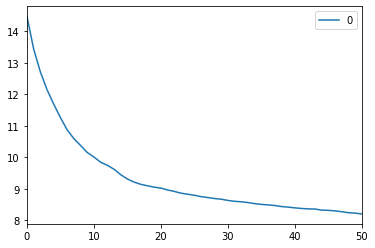

In [35]:
df=pd.DataFrame(booster0.trace)
df.plot()

<AxesSubplot:>

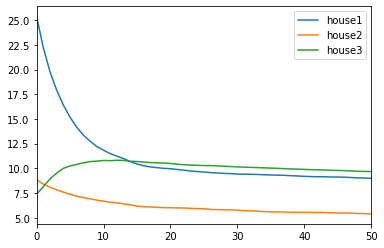

In [31]:
df0=pd.DataFrame(booster0.worker_trace, columns=["house1","house2","house3"])
df0.plot()

In [38]:
dtest=pd.DataFrame(booster0.worker_trace, columns=["house1","house2","house3"])
dtest.shape

(51, 3)

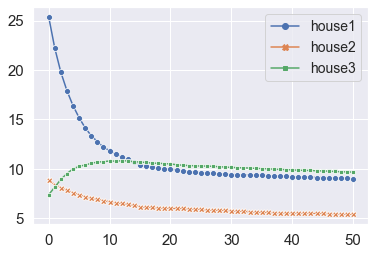

In [49]:
import seaborn as sns; #sns.set()
ax1=sns.lineplot(err_style="bars",  markers=True, dashes=False, data=dtest)
#ax1.grid()
ax1.legend(prop={'size': 14})
plt.tick_params(labelsize=15)
plt.show()

<AxesSubplot:>

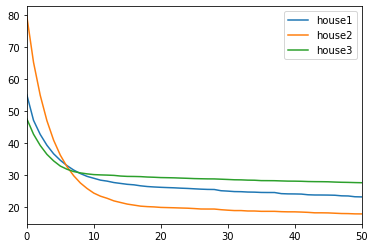

In [32]:
df1=pd.DataFrame(booster1.worker_trace,columns=["house1","house2","house3"])
df1.plot()

<AxesSubplot:>

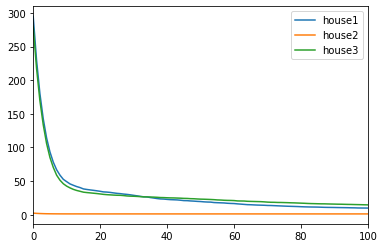

In [26]:
df2=pd.DataFrame(booster2.worker_trace,columns=["house1","house2","house3"])
df2.plot()

<AxesSubplot:>

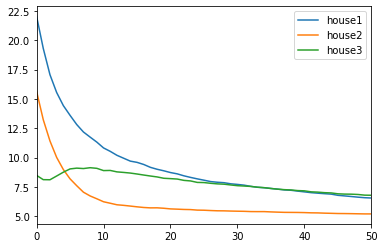

In [34]:
df3=pd.DataFrame(booster3.worker_trace,columns=["house1","house2","house3"])
df3.plot()

In [31]:
booster0.client=None
booster1.client=None
booster2.client=None
booster3.client=None
# model0='F:/NILM/BuildSYS/REDD_dask/dishwasher.pkl'
# with open(model0, 'wb+') as f:
#     boost= pickle.dump(booster0, f)
# model1='F:/NILM/BuildSYS/REDD_dask/fridge.pkl'
# with open(model1, 'wb+') as f:
#     boost= pickle.dump(booster1, f)
# model2='F:/NILM/BuildSYS/REDD_dask/washingmachine.pkl'  
# with open(model2, 'wb+') as f:
#     boost= pickle.dump(booster2, f)
model3='F:/NILM/BuildSYS/REDD_dask/microwave.pkl'   
with open(model3, 'wb+') as f:
    boost= pickle.dump(booster3, f)

In [60]:
booster0.client=None
model0='F:/NILM/BuildSYS/REDD_dask/dishwasher.pkl'
with open(model0, 'rb+') as f:
    boostest= pickle.load(f)
boostest.ensemble

[{9: {'<=1195.15625': {9: {'<=905.72': {9: {'<=477.0750000000001': {9: {'<=372.3525': {9: {'<=281.66125': {6: {'<=106.27625': {9: {'<=108.575': {11: {'<=32.260000000000005': 2.1527275541870554,
                 '>32.260000000000005': {14: {'<=1145.7399999999998': {9: {'<=33.471250000000005': {17: {'<=33.15750000000001': 0.23675736332520828,
                       '>33.15750000000001': 0.8874276443937669}},
                     '>33.471250000000005': {14: {'<=91.25166666666668': 0.08465263692737915,
                       '>91.25166666666668': 0.014083479435946003}}}},
                   '>1145.7399999999998': 1.5744052424228325}}}},
               '>108.575': {17: {'<=289.83125': {1: {'<=106.32375': {9: {'<=233.77625': 0.03627857878225199,
                     '>233.77625': 0.14867217166680088}},
                   '>106.32375': 10.528969164843058}},
                 '>289.83125': 10.614161813840113}}}},
             '>106.27625': {5: {'<=286.2425': {6: {'<=164.00125': {0: {'<=93.82': 

In [23]:
trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
testfile="F:/NILM/training_data/dishwasher_test_.csv"
X, Y = dataProvider(testfile, trainfile1, trainfile2, windowsize=19)
x_train_all, x_predict, y_train_all, y_predict = train_test_split(X, Y, test_size=0.2, random_state=100)
prediction=booster.predict(x_predict)
mae=mean_absolute_error(y_predict, prediction)
mae

9.047531425118484

In [2]:
def dataProvider(train1, train2, train3,windowsize):
    offset = int(0.5 * (windowsize - 1.0))
    data_frame1 = pd.read_csv(train1,
                             #chunksize=10 ** 3,
                             header=0
                             )
    data_frame2 = pd.read_csv(train2,
                             #chunksize=10 ** 3,
                             header=0
                             )
    data_frame3 = pd.read_csv(train3,
                             #chunksize=10 ** 3,
                             header=0
                             )

    np_array = np.array(data_frame1)
    inputs, targets = np_array[:, 0], np_array[:, 1]
    window_num=inputs.size - 2 * offset
    features=list()
    labels=list()
    for i in range(0,window_num):
        inp=inputs[i:i+windowsize]
        tar=targets[i+offset]
        features.append(inp)
        labels.append(tar)
    features0=np.array(features)
    labels0=np.array(labels)

    np_array = np.array(data_frame2)
    inputs, targets = np_array[:, 0], np_array[:, 1]
    window_num=inputs.size - 2 * offset
    features=list()
    labels=list()
    for i in range(0,window_num):
        inp=inputs[i:i+windowsize]
        tar=targets[i+offset]
        features.append(inp)
        labels.append(tar)
    features1=np.array(features)
    labels1=np.array(labels)

    np_array = np.array(data_frame3)
    inputs, targets = np_array[:, 0], np_array[:, 1]
    window_num=inputs.size - 2 * offset
    features=list()
    labels=list()
    for i in range(0,window_num):
        inp=inputs[i:i+windowsize]
        tar=targets[i+offset]
        features.append(inp)
        labels.append(tar)
    features2=np.array(features)
    labels2=np.array(labels)

    feature=np.concatenate((features0, features1), axis=0)
    feature=np.concatenate((feature, features2), axis=0)
    label=np.concatenate((labels0, labels1), axis=0)
    label=np.concatenate((label, labels2), axis=0)
    return feature, label

In [38]:
import xgboost as xgb
trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
testfile="F:/NILM/training_data/dishwasher_test_.csv"
# X, Y = dataProvider(testfile, trainfile1, trainfile2, windowsize=19)
# x_train_all, x_predict, y_train_all, y_predict = train_test_split(X, Y, test_size=0.2, random_state=100)
# x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size=0.2,random_state=100)
model=xgb.XGBRegressor(max_depth=10, learning_rate=0.3,verbosity=2, n_estimators=50,objective='reg:squarederror', booster='gbtree', n_jobs=4, subsample=0.7, colsample_bytree=0.7 )
train=(x_train, y_train)
test=(x_test, y_test)
model.fit(x_train, y_train, eval_metric=['mae'],eval_set=[train, test], verbose=True, early_stopping_rounds=10,callbacks=None)

[12:09:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-mae:6.96068	validation_1-mae:7.53631
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[12:09:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-mae:5.29380	validation_1-mae:6.02887
[12:09:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 526 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-mae:4.12880	validation_1-mae:4.99552
[12:09:12] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 574 extra nodes, 0 pruned nodes, max_de

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.3, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
             validate_parameters=False, verbosity=2)

In [31]:
prediction=model.predict(x_predict)
mae=mean_absolute_error(y_predict, prediction)
mae

9.072117653779127

In [34]:
def dataProvider_0(train1,  windowsize):
    offset = int(0.5 * (windowsize - 1.0))
    data_frame1 = pd.read_csv(train1,
                             #chunksize=10 ** 3,
                             header=0
                             )

    # data_frame3 = pd.read_csv(train3,
    #                          #chunksize=10 ** 3,
    #                          header=0
    #                          )

    np_array = np.array(data_frame1,dtype=np.float16)
    inputs, targets = np_array[:, 0], np_array[:, 1]
    window_num=inputs.size - 2 * offset
    features=list()
    labels=list()
    for i in range(0,window_num):
        inp=inputs[i:i+windowsize]
        tar=targets[i+offset]
        features.append(inp)
        labels.append(tar)
    features0=np.array(features,dtype=np.float16)
    labels0=np.array(labels,dtype=np.float16)
    return features0, labels0

In [36]:
trainfile1 = "F:/NILM/training_data/washingmachine_house_2_training_.csv"
X,Y=dataProvider_0(trainfile1, 19)
x_train_all, x_predict, y_train_all, y_predict = train_test_split(X, Y, test_size=0.2,random_state=100)
x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size=0.2,random_state=100)

[1]	training's l2: 0.455474	training's l1: 0.43221	validation's l2: 0.455437	validation's l1: 0.433547
[2]	training's l2: 0.425793	training's l1: 0.421929	validation's l2: 0.426813	validation's l1: 0.424064
[3]	training's l2: 0.407832	training's l1: 0.415264	validation's l2: 0.409056	validation's l1: 0.417782
[4]	training's l2: 0.39174	training's l1: 0.408764	validation's l2: 0.395053	validation's l1: 0.412162
[5]	training's l2: 0.382883	training's l1: 0.40473	validation's l2: 0.38784	validation's l1: 0.408994
[6]	training's l2: 0.375644	training's l1: 0.401292	validation's l2: 0.381937	validation's l1: 0.4061
[7]	training's l2: 0.368682	training's l1: 0.397935	validation's l2: 0.376062	validation's l1: 0.40347
[8]	training's l2: 0.371847	training's l1: 0.399502	validation's l2: 0.379007	validation's l1: 0.404896
[9]	training's l2: 0.366071	training's l1: 0.396499	validation's l2: 0.374518	validation's l1: 0.402717
[10]	training's l2: 0.362625	training's l1: 0.395328	validation's l2: 0

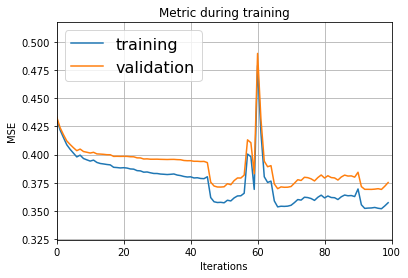

In [40]:
dtrain = lgb.Dataset(x_train, y_train)
dvalid = lgb.Dataset(x_test, y_test)
params = {
        'boosting': 'dart',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'num_leaves': 1000,
        # 'num_leaves': 2,
        'min_data_in_leaf': 20,
        'max_depth': 10,
        'learning_rate': 0.23179,
        # 'feature_fraction':argsDict['feature_fraction'],
        # 'bagging_fraction': argsDict['bagging_fraction'],
        # 'bagging_freq': argsDict['bagging_freq'],
        'max_bin':1000,
        # 'num_boost_round':argsDict['num_boost_rount'] ,
        'min_data_in_bin': 100,
        'lambda_l2': 0,
        'lambda_l1': 0.7145,
        'verbose': -1,
        'is_provide_training_metric': True,
        # 'bin_construct_sample_cnt': 59139
}
evals_result={}
gbm = lgb.train(params, dtrain, num_boost_round=100, valid_sets=[dtrain,dvalid], valid_names=["training","validation"], evals_result=evals_result, early_stopping_rounds=10)
lgb.plot_metric(evals_result, metric='l1', ylabel="MSE")
plt.legend( prop={'size': 16})
plt.show()

In [33]:
prediction=gbm.predict(x_predict)
mae=mean_absolute_error(y_predict, prediction)
mae

11.770448236641053

In [25]:
def lgbbest_train(x_train,y_train, cores):
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2,random_state=100)
    dtrain = lgb.Dataset(x_train, y_train)
# dvalidv1= lgb.Dataset(x_test,y_test)
    dvalid = lgb.Dataset(x_test, y_test)
    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'num_leaves': 900,
        # 'num_leaves': 2,
        'min_data_in_leaf': 100,
        'max_depth': 10,
        'learning_rate': 0.23179,
        # 'feature_fraction':argsDict['feature_fraction'],
        # 'bagging_fraction': argsDict['bagging_fraction'],
        # 'bagging_freq': argsDict['bagging_freq'],
        'max_bin':100,
        # 'num_boost_round':argsDict['num_boost_rount'] ,
        'min_data_in_bin': 200,
        'lambda_l2': 0.00001,
        'lambda_l1': 0.02145,
        'verbose': -1,
        'is_provide_training_metric': True,
        'num_threads':cores
        # 'bin_construct_sample_cnt': 59139
    }
    evals_result={}
    gbm = lgb.train(params, dtrain, num_boost_round=500, valid_sets=[dtrain,dvalid], valid_names=["training","validation"], evals_result=evals_result, early_stopping_rounds=30)
    # gbm.save_model('F:/NILM/model/redd/lightGBM_fridgeN1.txt')
#     loss=get_tranformer_score(gbm,xtest,ytest)
#     print(type(gbm))
#     print(evals_result)
    lgb.plot_metric(evals_result, metric='l1', ylabel="MSE")
    plt.legend( prop={'size': 16})
    plt.show()
    return gbm

In [152]:
def lgbbest_train1(x_train,y_train):
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2,random_state=100)
    dtrain = lgb.Dataset(x_train, y_train)
# dvalidv1= lgb.Dataset(x_test,y_test)
    dvalid = lgb.Dataset(x_test, y_test)
    params = {
        'boosting': 'gbdt',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'num_leaves': 1000,
        # 'num_leaves': 2,
        'min_data_in_leaf': 100,
        'max_depth': 15,
        'learning_rate': 0.07179,
        # 'feature_fraction':argsDict['feature_fraction'],
        # 'bagging_fraction': argsDict['bagging_fraction'],
        # 'bagging_freq': argsDict['bagging_freq'],
        'max_bin':5000,
        # 'num_boost_round':argsDict['num_boost_rount'] ,
        'min_data_in_bin': 100,
        'lambda_l2': 0.0001,
        'lambda_l1': 0.2145,
        'verbose': -1,
        'is_provide_training_metric': True,
        # 'bin_construct_sample_cnt': 59139
    }
    evals_result={}
    gbm = lgb.train(params, dtrain, num_boost_round=700, valid_sets=[dtrain,dvalid], valid_names=["training","validation"], evals_result=evals_result, early_stopping_rounds=20)
    # gbm.save_model('F:/NILM/model/redd/lightGBM_fridgeN1.txt')
#     loss=get_tranformer_score(gbm,xtest,ytest)
#     print(type(gbm))
#     print(evals_result)
    lgb.plot_metric(evals_result, metric='l1', ylabel="MSE")
    plt.legend( prop={'size': 16})
    plt.show()
    return gbm

In [6]:
trainfile1 = "F:/NILM/training_data/dishwasher_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/dishwasher_house_3_training_.csv"
testfile="F:/NILM/training_data/dishwasher_test_.csv"
data_frame1 = pd.read_csv(trainfile1,
                             #chunksize=10 ** 3,
                             header=0
                             )
data_frame2 = pd.read_csv(trainfile2,
                             #chunksize=10 ** 3,
                             header=0
                             )
data_frame3 = pd.read_csv(testfile,
                             #chunksize=10 ** 3,
                             header=0
                             )
x_train1, y_train1, x_test1,  y_test1,x_predict1, y_predict1=EMDpreprocess(data_frame1)
x_train2, y_train2, x_test2,  y_test2,x_predict2, y_predict2=EMDpreprocess(data_frame2)
x_train3, y_train3, x_test3,  y_test3,x_predict3, y_predict3=EMDpreprocess(data_frame3)
x_train=np.concatenate((x_train1,x_train2,x_train3), axis=0)
y_train=np.concatenate((y_train1,y_train2,y_train3), axis=0)
x_predict=np.concatenate((x_test1,x_test2,x_test3), axis=0)
y_predict=np.concatenate((y_test1,y_test2,y_test3), axis=0)

[1]	training's l1: 41.0408	training's l2: 15815.3	validation's l1: 41.2277	validation's l2: 15906.4
Training until validation scores don't improve for 30 rounds
[2]	training's l1: 35.0848	training's l2: 11514.9	validation's l1: 35.3749	validation's l2: 11609.2
[3]	training's l1: 30.4529	training's l2: 8914.77	validation's l1: 30.7872	validation's l2: 9028.87
[4]	training's l1: 26.8907	training's l2: 7344.5	validation's l1: 27.2697	validation's l2: 7490.81
[5]	training's l1: 24.0857	training's l2: 6364.34	validation's l1: 24.506	validation's l2: 6542.08
[6]	training's l1: 21.914	training's l2: 5747.39	validation's l1: 22.3901	validation's l2: 5974.64
[7]	training's l1: 20.2227	training's l2: 5320.84	validation's l1: 20.7218	validation's l2: 5582.96
[8]	training's l1: 18.8924	training's l2: 5049.09	validation's l1: 19.411	validation's l2: 5340.02
[9]	training's l1: 17.8161	training's l2: 4863.33	validation's l1: 18.3615	validation's l2: 5178.19
[10]	training's l1: 16.9924	training's l2: 

[161]	training's l1: 12.4322	training's l2: 3447.67	validation's l1: 14.1472	validation's l2: 4366.46
[162]	training's l1: 12.4262	training's l2: 3446.65	validation's l1: 14.139	validation's l2: 4366.06
[163]	training's l1: 12.423	training's l2: 3444.66	validation's l1: 14.1396	validation's l2: 4365.26
[164]	training's l1: 12.4211	training's l2: 3442.54	validation's l1: 14.1352	validation's l2: 4360.23
[165]	training's l1: 12.4138	training's l2: 3440.9	validation's l1: 14.1345	validation's l2: 4361.72
[166]	training's l1: 12.4125	training's l2: 3438.18	validation's l1: 14.1396	validation's l2: 4361.33
[167]	training's l1: 12.4096	training's l2: 3435.01	validation's l1: 14.1449	validation's l2: 4360.28
[168]	training's l1: 12.4016	training's l2: 3434.03	validation's l1: 14.1436	validation's l2: 4361.67
[169]	training's l1: 12.3952	training's l2: 3431.55	validation's l1: 14.1426	validation's l2: 4360.24
[170]	training's l1: 12.3953	training's l2: 3429.9	validation's l1: 14.147	validation

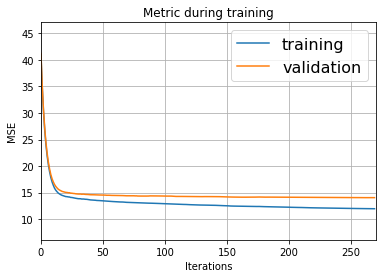

Wall time: 2.31 s


In [34]:
%%time
booster1=lgbbest_train(x_train3,y_train3,2)

[1]	training's l1: 15.478	training's l2: 7239.03	validation's l1: 15.9413	validation's l2: 7567.05
Training until validation scores don't improve for 30 rounds
[2]	training's l1: 14.0547	training's l2: 6125.82	validation's l1: 14.5615	validation's l2: 6469.29
[3]	training's l1: 12.9693	training's l2: 5454.18	validation's l1: 13.4693	validation's l2: 5792.3
[4]	training's l1: 12.1031	training's l2: 5021.48	validation's l1: 12.653	validation's l2: 5390.08
[5]	training's l1: 11.4198	training's l2: 4740.74	validation's l1: 11.9692	validation's l2: 5105.06
[6]	training's l1: 10.9306	training's l2: 4571.67	validation's l1: 11.4813	validation's l2: 4946.41
[7]	training's l1: 10.5474	training's l2: 4451.16	validation's l1: 11.135	validation's l2: 4856.68
[8]	training's l1: 10.2715	training's l2: 4350.53	validation's l1: 10.8807	validation's l2: 4788.65
[9]	training's l1: 10.057	training's l2: 4292.03	validation's l1: 10.6824	validation's l2: 4755.86
[10]	training's l1: 9.89898	training's l2: 4

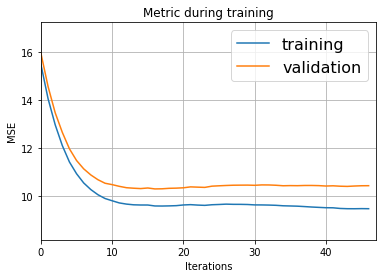

Wall time: 554 ms


In [27]:
%%time
booster1=lgbbest_train(x_train1,y_train1,2)

[1]	training's l2: 7239.03	training's l1: 15.478	validation's l2: 7567.05	validation's l1: 15.9413
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 6125.82	training's l1: 14.0547	validation's l2: 6469.29	validation's l1: 14.5615
[3]	training's l2: 5454.18	training's l1: 12.9693	validation's l2: 5792.3	validation's l1: 13.4693
[4]	training's l2: 5021.48	training's l1: 12.1031	validation's l2: 5390.08	validation's l1: 12.653
[5]	training's l2: 4740.74	training's l1: 11.4198	validation's l2: 5105.06	validation's l1: 11.9692
[6]	training's l2: 4571.67	training's l1: 10.9306	validation's l2: 4946.41	validation's l1: 11.4813
[7]	training's l2: 4451.16	training's l1: 10.5474	validation's l2: 4856.68	validation's l1: 11.135
[8]	training's l2: 4350.53	training's l1: 10.2715	validation's l2: 4788.65	validation's l1: 10.8807
[9]	training's l2: 4292.03	training's l1: 10.057	validation's l2: 4755.86	validation's l1: 10.6824
[10]	training's l2: 4248.97	training's l1: 9

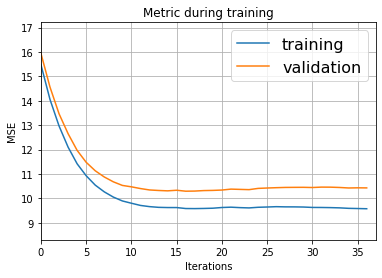

mae is : 9.985834900917377
sae is : 0.0035266615715367393
nde of this model is: 0.6772639570915735
[1]	training's l2: 3942.06	training's l1: 12.2187	validation's l2: 3935.34	validation's l1: 12.2836
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 3692.96	training's l1: 11.7131	validation's l2: 3677.81	validation's l1: 11.7799
[3]	training's l2: 3520.61	training's l1: 11.3014	validation's l2: 3496.68	validation's l1: 11.3669
[4]	training's l2: 3417.26	training's l1: 10.99	validation's l2: 3385.25	validation's l1: 11.0615
[5]	training's l2: 3343.87	training's l1: 10.7493	validation's l2: 3310.12	validation's l1: 10.8445
[6]	training's l2: 3292.13	training's l1: 10.5615	validation's l2: 3258.46	validation's l1: 10.6592
[7]	training's l2: 3257.37	training's l1: 10.4334	validation's l2: 3224	validation's l1: 10.5358
[8]	training's l2: 3232	training's l1: 10.3328	validation's l2: 3202.25	validation's l1: 10.4327
[9]	training's l2: 3207.66	training's l1: 10.259

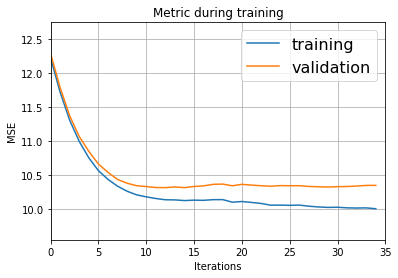

mae is : 10.348804890589307
sae is : 0.045531507773599586
nde of this model is: 0.8588153269950723
[1]	training's l2: 15815.3	training's l1: 41.0408	validation's l2: 15906.4	validation's l1: 41.2277
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 11514.9	training's l1: 35.0848	validation's l2: 11609.2	validation's l1: 35.3749
[3]	training's l2: 8914.77	training's l1: 30.4529	validation's l2: 9028.87	validation's l1: 30.7872
[4]	training's l2: 7344.5	training's l1: 26.8907	validation's l2: 7490.81	validation's l1: 27.2697
[5]	training's l2: 6364.34	training's l1: 24.0857	validation's l2: 6542.08	validation's l1: 24.506
[6]	training's l2: 5747.39	training's l1: 21.914	validation's l2: 5974.64	validation's l1: 22.3901
[7]	training's l2: 5320.84	training's l1: 20.2227	validation's l2: 5582.96	validation's l1: 20.7218
[8]	training's l2: 5049.09	training's l1: 18.8924	validation's l2: 5340.02	validation's l1: 19.411
[9]	training's l2: 4863.33	training's l1: 17

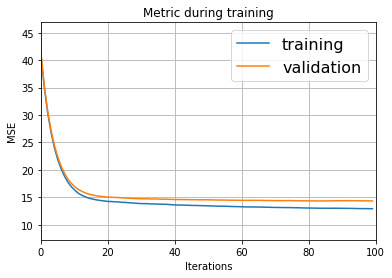

mae is : 14.483683639942978
sae is : 0.020445197264232738
nde of this model is: 0.43010406104578125
mae is : 11.781255727009194
sae is : 0.020489882835397353
nde of this model is: 0.5521282720821731


In [86]:
booster1=lgbbest_train(x_train1,y_train1)
prediction1=booster1.predict(x_test1)
# mae=mean_absolute_error(y_test1, prediction)
prediction1=np.float64(prediction1)
y_test1=np.float64(y_test1)
score(y_test1, prediction1)

booster2=lgbbest_train(x_train2,y_train2)
prediction2=booster2.predict(x_test2)
prediction2=np.float64(prediction2)
y_test2=np.float64(y_test2)
score(y_test2, prediction2)

booster3=lgbbest_train(x_train3,y_train3)
prediction3=booster3.predict(x_test3)
prediction3=np.float64(prediction3)
y_test3=np.float64(y_test3)
score(y_test3, prediction3)

prediction=np.concatenate([prediction1, prediction2, prediction3],axis=0)
y_predict=np.concatenate([y_test1,y_test2,y_test3],axis=0)
score(y_predict,prediction)

In [70]:
model0='F:/NILM/BuildSYS/REDD_dask/dishwasher.pkl'
with open(model0, 'rb+') as f:
    booster0= pickle.load(f)
prediction=booster0.predict(x_predict)
prediction=np.float64(prediction)
y_predict=np.float64(y_predict)
score(y_predict, prediction)

mae is : 9.595256238787602
sae is : 0.006388832952313546
nde of this model is: 0.4254343294563913


In [155]:
model0='F:/NILM/BuildSYS/REDD_dask/dishwasher.pkl'
with open(model0, 'rb+') as f:
    booster0= pickle.load(f)
prediction1=booster0.predict(x_test1)
# mae=mean_absolute_error(y_test1, prediction)
prediction1=np.float64(prediction1)
y_test1=np.float64(y_test1)
score(y_test1, prediction1)

prediction2=booster0.predict(x_test2)
prediction2=np.float64(prediction2)
y_test2=np.float64(y_test2)
score(y_test2, prediction2)


prediction3=booster0.predict(x_test3)
prediction3=np.float64(prediction3)
y_test3=np.float64(y_test3)
score(y_test3, prediction3)

mae is : 6.129934104788673
sae is : 0.009114029123726467
nde of this model is: 0.3923248624588348
mae is : 11.705971125603673
sae is : 0.6315211725223406
nde of this model is: 0.8070877105456497
mae is : 10.27023479012882
sae is : 0.15443871402575346
nde of this model is: 0.3311945355827862


[1]	training's l2: 11509.9	training's l1: 26.6189	validation's l2: 11164.5	validation's l1: 26.2811
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 10447	training's l1: 25.4772	validation's l2: 10168.3	validation's l1: 25.1942
[3]	training's l2: 9530.95	training's l1: 24.4198	validation's l2: 9311.8	validation's l1: 24.1909
[4]	training's l2: 8731.87	training's l1: 23.4324	validation's l2: 8562.66	validation's l1: 23.2474
[5]	training's l2: 8041.39	training's l1: 22.5135	validation's l2: 7920.72	validation's l1: 22.3773
[6]	training's l2: 7436.65	training's l1: 21.6515	validation's l2: 7358.08	validation's l1: 21.5587
[7]	training's l2: 6919.5	training's l1: 20.8542	validation's l2: 6877.71	validation's l1: 20.8053
[8]	training's l2: 6462.27	training's l1: 20.1045	validation's l2: 6450.23	validation's l1: 20.0859
[9]	training's l2: 6067.94	training's l1: 19.4122	validation's l2: 6083.91	validation's l1: 19.4263
[10]	training's l2: 5716.58	training's l1: 

[162]	training's l2: 2224.17	training's l1: 9.16849	validation's l2: 3036.78	validation's l1: 10.5208
[163]	training's l2: 2220.45	training's l1: 9.16109	validation's l2: 3034.39	validation's l1: 10.519
[164]	training's l2: 2218.25	training's l1: 9.1585	validation's l2: 3033.1	validation's l1: 10.5189
[165]	training's l2: 2215.05	training's l1: 9.15293	validation's l2: 3031.09	validation's l1: 10.5165
[166]	training's l2: 2212.81	training's l1: 9.14719	validation's l2: 3029.88	validation's l1: 10.5164
[167]	training's l2: 2211.57	training's l1: 9.14314	validation's l2: 3029.12	validation's l1: 10.5145
[168]	training's l2: 2209.4	training's l1: 9.1386	validation's l2: 3026.54	validation's l1: 10.5114
[169]	training's l2: 2205.64	training's l1: 9.12691	validation's l2: 3024.2	validation's l1: 10.5057
[170]	training's l2: 2203.99	training's l1: 9.12061	validation's l2: 3023.3	validation's l1: 10.5023
[171]	training's l2: 2202.21	training's l1: 9.11905	validation's l2: 3022.17	validation's

[322]	training's l2: 1817.66	training's l1: 8.46445	validation's l2: 2814.24	validation's l1: 10.3336
[323]	training's l2: 1816.57	training's l1: 8.45919	validation's l2: 2813.44	validation's l1: 10.3298
[324]	training's l2: 1815.56	training's l1: 8.45595	validation's l2: 2812.97	validation's l1: 10.3289
[325]	training's l2: 1812.86	training's l1: 8.45148	validation's l2: 2810.75	validation's l1: 10.3261
[326]	training's l2: 1810.51	training's l1: 8.44624	validation's l2: 2809.8	validation's l1: 10.3233
[327]	training's l2: 1807.7	training's l1: 8.44187	validation's l2: 2808.62	validation's l1: 10.3235
[328]	training's l2: 1805.71	training's l1: 8.43831	validation's l2: 2807.81	validation's l1: 10.3219
[329]	training's l2: 1804.61	training's l1: 8.43488	validation's l2: 2806.97	validation's l1: 10.3202
[330]	training's l2: 1803.49	training's l1: 8.43273	validation's l2: 2806.34	validation's l1: 10.3198
[331]	training's l2: 1801.22	training's l1: 8.42737	validation's l2: 2806.3	validati

[482]	training's l2: 1603.58	training's l1: 8.0103	validation's l2: 2699.68	validation's l1: 10.2109
[483]	training's l2: 1602.62	training's l1: 8.00729	validation's l2: 2699.23	validation's l1: 10.2113
[484]	training's l2: 1601.28	training's l1: 8.00458	validation's l2: 2699.24	validation's l1: 10.2121
[485]	training's l2: 1600.33	training's l1: 8.00347	validation's l2: 2699.21	validation's l1: 10.2129
[486]	training's l2: 1599.22	training's l1: 8.00174	validation's l2: 2699.63	validation's l1: 10.2147
[487]	training's l2: 1598.52	training's l1: 7.99851	validation's l2: 2699.46	validation's l1: 10.2135
[488]	training's l2: 1596.24	training's l1: 7.99233	validation's l2: 2698.52	validation's l1: 10.2118
[489]	training's l2: 1595.05	training's l1: 7.98879	validation's l2: 2697.76	validation's l1: 10.2115
[490]	training's l2: 1594.3	training's l1: 7.98487	validation's l2: 2697.27	validation's l1: 10.209
[491]	training's l2: 1593.43	training's l1: 7.98238	validation's l2: 2697.11	validati

[642]	training's l2: 1450.96	training's l1: 7.63797	validation's l2: 2617.53	validation's l1: 10.1136
[643]	training's l2: 1449.69	training's l1: 7.63456	validation's l2: 2617.62	validation's l1: 10.1136
[644]	training's l2: 1448.47	training's l1: 7.63302	validation's l2: 2617.11	validation's l1: 10.113
[645]	training's l2: 1447.22	training's l1: 7.62823	validation's l2: 2615.67	validation's l1: 10.1079
[646]	training's l2: 1446.07	training's l1: 7.62555	validation's l2: 2614.98	validation's l1: 10.107
[647]	training's l2: 1444.58	training's l1: 7.62297	validation's l2: 2612.76	validation's l1: 10.1052
[648]	training's l2: 1443.56	training's l1: 7.61988	validation's l2: 2612.2	validation's l1: 10.1041
[649]	training's l2: 1442.17	training's l1: 7.61697	validation's l2: 2611.81	validation's l1: 10.103
[650]	training's l2: 1441.19	training's l1: 7.61501	validation's l2: 2611.84	validation's l1: 10.1039
[651]	training's l2: 1440.16	training's l1: 7.61289	validation's l2: 2611.42	validatio

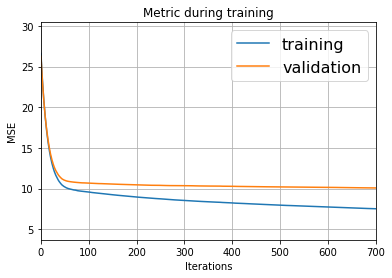

mae is : 10.043523355969558
sae is : 0.010570909757689586
nde of this model is: 0.4444340553273183


In [153]:
booster=lgbbest_train1(x_train,y_train)
prediction=booster.predict(x_predict)
prediction=np.float64(prediction)
y_predict=np.float64(y_predict)
score(y_predict, prediction)

In [156]:
trainfile1 = "F:/NILM/training_data/fridge_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/fridge_house_3_training_.csv"
testfile="F:/NILM/training_data/fridge_test_.csv"
data_frame1 = pd.read_csv(trainfile1,
                             #chunksize=10 ** 3,
                             header=0
                             )
data_frame2 = pd.read_csv(trainfile2,
                             #chunksize=10 ** 3,
                             header=0
                             )
data_frame3 = pd.read_csv(testfile,
                             #chunksize=10 ** 3,
                             header=0
                             )
x_train1, y_train1, x_test1,  y_test1,x_predict1, y_predict1=EMDpreprocess(data_frame1)
x_train2, y_train2, x_test2,  y_test2,x_predict2, y_predict2=EMDpreprocess(data_frame2)
x_train3, y_train3, x_test3,  y_test3,x_predict3, y_predict3=EMDpreprocess(data_frame3)
x_train=np.concatenate((x_train1,x_train2,x_train3), axis=0)
y_train=np.concatenate((y_train1,y_train2,y_train3), axis=0)
x_predict=np.concatenate((x_test1,x_test2,x_test3), axis=0)
y_predict=np.concatenate((y_test1,y_test2,y_test3), axis=0)

[1]	training's l2: 5254.26	training's l1: 65.185	validation's l2: 5096.7	validation's l1: 65.0857
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 3768.89	training's l1: 52.656	validation's l2: 3627.07	validation's l1: 52.6265
[3]	training's l2: 2872.93	training's l1: 43.1928	validation's l2: 2743.55	validation's l1: 43.1871
[4]	training's l2: 2335.88	training's l1: 35.9653	validation's l2: 2219.73	validation's l1: 35.9939
[5]	training's l2: 2014	training's l1: 30.4785	validation's l2: 1905.86	validation's l1: 30.5322
[6]	training's l2: 1815.02	training's l1: 26.2464	validation's l2: 1708.86	validation's l1: 26.2925
[7]	training's l2: 1689.83	training's l1: 23.0094	validation's l2: 1590.58	validation's l1: 23.0772
[8]	training's l2: 1598.71	training's l1: 20.4566	validation's l2: 1502.24	validation's l1: 20.5373
[9]	training's l2: 1542.87	training's l1: 18.5736	validation's l2: 1451.06	validation's l1: 18.6802
[10]	training's l2: 1502.9	training's l1: 17.

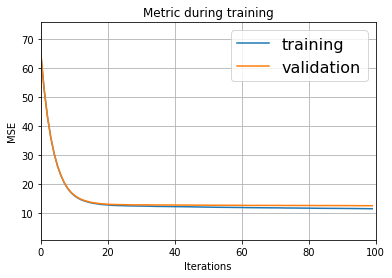

mae is : 12.515698582940495
sae is : 0.0019896637659370855
nde of this model is: 0.2992049977835313
[1]	training's l2: 3629.96	training's l1: 51.2768	validation's l2: 3643.06	validation's l1: 51.3939
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 3111.84	training's l1: 45.5319	validation's l2: 3146.73	validation's l1: 45.774
[3]	training's l2: 2801.96	training's l1: 41.1132	validation's l2: 2849.65	validation's l1: 41.4404
[4]	training's l2: 2595.28	training's l1: 37.6581	validation's l2: 2654.03	validation's l1: 38.0613
[5]	training's l2: 2465.42	training's l1: 34.9574	validation's l2: 2535.13	validation's l1: 35.4249
[6]	training's l2: 2381.74	training's l1: 32.852	validation's l2: 2459.46	validation's l1: 33.3849
[7]	training's l2: 2327.22	training's l1: 31.234	validation's l2: 2411.34	validation's l1: 31.8212
[8]	training's l2: 2290.7	training's l1: 29.9973	validation's l2: 2381.14	validation's l1: 30.6259
[9]	training's l2: 2265.84	training's l1: 2

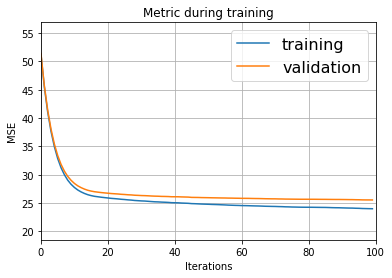

mae is : 25.629192727943316
sae is : 0.011238618160517102
nde of this model is: 0.5742634163866537
[1]	training's l2: 5593.44	training's l1: 61.0781	validation's l2: 5704.81	validation's l1: 61.0523
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 4391.76	training's l1: 52.1937	validation's l2: 4512.17	validation's l1: 52.1989
[3]	training's l2: 3675.56	training's l1: 45.4229	validation's l2: 3802.45	validation's l1: 45.4811
[4]	training's l2: 3223.53	training's l1: 40.0992	validation's l2: 3355.7	validation's l1: 40.1823
[5]	training's l2: 2940.1	training's l1: 35.9234	validation's l2: 3083.56	validation's l1: 36.072
[6]	training's l2: 2752.34	training's l1: 32.6676	validation's l2: 2898.87	validation's l1: 32.8493
[7]	training's l2: 2638.01	training's l1: 30.1787	validation's l2: 2790.23	validation's l1: 30.3941
[8]	training's l2: 2552.79	training's l1: 28.227	validation's l2: 2707.81	validation's l1: 28.4669
[9]	training's l2: 2486.55	training's l1: 26

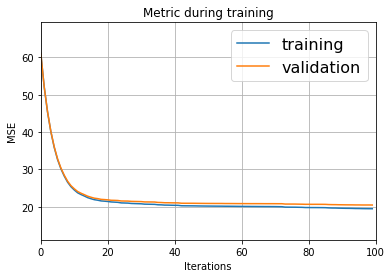

mae is : 20.560616849493506
sae is : 0.0002676423708489607
nde of this model is: 0.4589449278312241
mae is : 20.037088603938884
sae is : 0.0022895476062178848
nde of this model is: 0.4380736074014326


In [98]:
booster1=lgbbest_train(x_train1,y_train1)
prediction1=booster1.predict(x_test1)
# mae=mean_absolute_error(y_test1, prediction)
prediction1=np.float64(prediction1)
y_test1=np.float64(y_test1)
score(y_test1, prediction1)

booster2=lgbbest_train(x_train2,y_train2)
prediction2=booster2.predict(x_test2)
prediction2=np.float64(prediction2)
y_test2=np.float64(y_test2)
score(y_test2, prediction2)

booster3=lgbbest_train(x_train3,y_train3)
prediction3=booster3.predict(x_test3)
prediction3=np.float64(prediction3)
y_test3=np.float64(y_test3)
score(y_test3, prediction3)

prediction=np.concatenate([prediction1, prediction2, prediction3],axis=0)
y_predict=np.concatenate([y_test1,y_test2,y_test3],axis=0)
score(y_predict,prediction)

In [74]:
model0='F:/NILM/BuildSYS/REDD_dask/fridge.pkl'
with open(model0, 'rb+') as f:
    booster0= pickle.load(f)
prediction=booster0.predict(x_predict)
prediction=np.float64(prediction)
y_predict=np.float64(y_predict)
score(y_predict, prediction)

mae is : 23.387854451925715
sae is : 0.0006015112058851417
nde of this model is: 0.4487962657661962


In [157]:
model0='F:/NILM/BuildSYS/REDD_dask/fridge.pkl'
with open(model0, 'rb+') as f:
    booster0= pickle.load(f)
prediction1=booster0.predict(x_test1)
# mae=mean_absolute_error(y_test1, prediction)
prediction1=np.float64(prediction1)
y_test1=np.float64(y_test1)
score(y_test1, prediction1)

prediction2=booster0.predict(x_test2)
prediction2=np.float64(prediction2)
y_test2=np.float64(y_test2)
score(y_test2, prediction2)


prediction3=booster0.predict(x_test3)
prediction3=np.float64(prediction3)
y_test3=np.float64(y_test3)
score(y_test3, prediction3)

mae is : 17.34052126783164
sae is : 0.07084335647083782
nde of this model is: 0.3330588926256776
mae is : 28.88814985944048
sae is : 0.12729095448300945
nde of this model is: 0.6139035855912126
mae is : 22.87353575784741
sae is : 0.02700056771775701
nde of this model is: 0.4300253643466196


[1]	training's l2: 5745.58	training's l1: 65.2256	validation's l2: 5727.56	validation's l1: 65.4294
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 4985.36	training's l1: 59.7742	validation's l2: 4989.21	validation's l1: 60.0936
[3]	training's l2: 4393.88	training's l1: 55.0214	validation's l2: 4413.7	validation's l1: 55.438
[4]	training's l2: 3946.29	training's l1: 50.9148	validation's l2: 3981.62	validation's l1: 51.4136
[5]	training's l2: 3602.38	training's l1: 47.3569	validation's l2: 3650.47	validation's l1: 47.9326
[6]	training's l2: 3330.73	training's l1: 44.2465	validation's l2: 3393.67	validation's l1: 44.9079
[7]	training's l2: 3116.59	training's l1: 41.5747	validation's l2: 3191.87	validation's l1: 42.3099
[8]	training's l2: 2946.46	training's l1: 39.2054	validation's l2: 3032.02	validation's l1: 40.0093
[9]	training's l2: 2814.68	training's l1: 37.1832	validation's l2: 2907.76	validation's l1: 38.0448
[10]	training's l2: 2710.48	training's l1

[161]	training's l2: 1826.22	training's l1: 21.7519	validation's l2: 2156.28	validation's l1: 24.0011
[162]	training's l2: 1825.13	training's l1: 21.7439	validation's l2: 2155.96	validation's l1: 23.9982
[163]	training's l2: 1824.76	training's l1: 21.7413	validation's l2: 2155.81	validation's l1: 23.9974
[164]	training's l2: 1824.34	training's l1: 21.7375	validation's l2: 2155.66	validation's l1: 23.9962
[165]	training's l2: 1822.45	training's l1: 21.7243	validation's l2: 2154.93	validation's l1: 23.9905
[166]	training's l2: 1816.09	training's l1: 21.6961	validation's l2: 2151.68	validation's l1: 23.9775
[167]	training's l2: 1811.88	training's l1: 21.6772	validation's l2: 2149.28	validation's l1: 23.9666
[168]	training's l2: 1807.59	training's l1: 21.6518	validation's l2: 2146.45	validation's l1: 23.9481
[169]	training's l2: 1803.52	training's l1: 21.6185	validation's l2: 2144.55	validation's l1: 23.9275
[170]	training's l2: 1803.12	training's l1: 21.6152	validation's l2: 2144.35	valid

[321]	training's l2: 1599.08	training's l1: 20.2339	validation's l2: 2057.13	validation's l1: 23.2444
[322]	training's l2: 1597.04	training's l1: 20.2229	validation's l2: 2056.4	validation's l1: 23.2407
[323]	training's l2: 1594.27	training's l1: 20.2072	validation's l2: 2054.97	validation's l1: 23.235
[324]	training's l2: 1593.84	training's l1: 20.2032	validation's l2: 2054.7	validation's l1: 23.2324
[325]	training's l2: 1591.97	training's l1: 20.1898	validation's l2: 2054.34	validation's l1: 23.2284
[326]	training's l2: 1588.5	training's l1: 20.1708	validation's l2: 2052.58	validation's l1: 23.2177
[327]	training's l2: 1588.05	training's l1: 20.1668	validation's l2: 2052.29	validation's l1: 23.2155
[328]	training's l2: 1587.78	training's l1: 20.1655	validation's l2: 2052.17	validation's l1: 23.2151
[329]	training's l2: 1586.1	training's l1: 20.1555	validation's l2: 2051.46	validation's l1: 23.2113
[330]	training's l2: 1585.21	training's l1: 20.1485	validation's l2: 2050.88	validation

[481]	training's l2: 1419.62	training's l1: 18.9808	validation's l2: 1988.42	validation's l1: 22.7046
[482]	training's l2: 1419.54	training's l1: 18.98	validation's l2: 1988.36	validation's l1: 22.7037
[483]	training's l2: 1419.41	training's l1: 18.9788	validation's l2: 1988.33	validation's l1: 22.7035
[484]	training's l2: 1419.02	training's l1: 18.9754	validation's l2: 1988.11	validation's l1: 22.7014
[485]	training's l2: 1418.97	training's l1: 18.9747	validation's l2: 1988.12	validation's l1: 22.7014
[486]	training's l2: 1416.43	training's l1: 18.951	validation's l2: 1986.89	validation's l1: 22.6894
[487]	training's l2: 1414.2	training's l1: 18.9337	validation's l2: 1986.06	validation's l1: 22.6814
[488]	training's l2: 1413.82	training's l1: 18.9296	validation's l2: 1985.84	validation's l1: 22.679
[489]	training's l2: 1413.76	training's l1: 18.9288	validation's l2: 1985.81	validation's l1: 22.6789
[490]	training's l2: 1413.64	training's l1: 18.9277	validation's l2: 1985.72	validation

[641]	training's l2: 1314.23	training's l1: 18.1379	validation's l2: 1953.71	validation's l1: 22.3592
[642]	training's l2: 1314.17	training's l1: 18.1373	validation's l2: 1953.69	validation's l1: 22.3589
[643]	training's l2: 1314.13	training's l1: 18.1368	validation's l2: 1953.67	validation's l1: 22.3589
[644]	training's l2: 1314.08	training's l1: 18.1361	validation's l2: 1953.68	validation's l1: 22.3587
[645]	training's l2: 1313.03	training's l1: 18.1291	validation's l2: 1953.63	validation's l1: 22.3582
[646]	training's l2: 1312.21	training's l1: 18.1242	validation's l2: 1953.84	validation's l1: 22.358
[647]	training's l2: 1310.95	training's l1: 18.116	validation's l2: 1953.77	validation's l1: 22.3584
[648]	training's l2: 1310.02	training's l1: 18.1089	validation's l2: 1953.51	validation's l1: 22.3564
[649]	training's l2: 1308.25	training's l1: 18.0981	validation's l2: 1952.66	validation's l1: 22.3513
[650]	training's l2: 1307.45	training's l1: 18.0919	validation's l2: 1952.5	validati

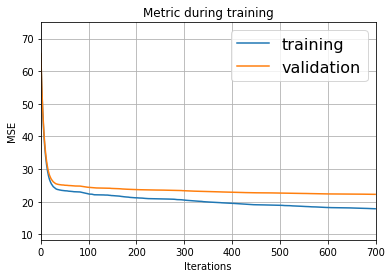

mae is : 22.16534533624454
sae is : 0.00038086298727301734
nde of this model is: 0.43589985544764137


In [137]:
booster=lgbbest_train1(x_train,y_train)
prediction=booster.predict(x_predict)
prediction=np.float64(prediction)
y_predict=np.float64(y_predict)
score(y_predict, prediction)

In [158]:
trainfile1 = "F:/NILM/training_data/washingmachine_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/washingmachine_house_3_training_.csv"
testfile="F:/NILM/training_data/washingmachine_test_.csv"
data_frame1 = pd.read_csv(trainfile1,
                             #chunksize=10 ** 3,
                             header=0
                             )
data_frame2 = pd.read_csv(trainfile2,
                             #chunksize=10 ** 3,
                             header=0
                             )
data_frame3 = pd.read_csv(testfile,
                             #chunksize=10 ** 3,
                             header=0
                             )
x_train1, y_train1, x_test1,  y_test1,x_predict1, y_predict1=EMDpreprocess(data_frame1)
x_train2, y_train2, x_test2,  y_test2,x_predict2, y_predict2=EMDpreprocess(data_frame2)
x_train3, y_train3, x_test3,  y_test3,x_predict3, y_predict3=EMDpreprocess(data_frame3)
x_train=np.concatenate((x_train1,x_train2,x_train3), axis=0)
y_train=np.concatenate((y_train1,y_train2,y_train3), axis=0)
x_predict=np.concatenate((x_test1,x_test2,x_test3), axis=0)
y_predict=np.concatenate((y_test1,y_test2,y_test3), axis=0)

[1]	training's l2: 0.470373	training's l1: 0.437055	validation's l2: 0.469721	validation's l1: 0.438263
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 0.450798	training's l1: 0.431642	validation's l2: 0.451205	validation's l1: 0.433723
[3]	training's l2: 0.438191	training's l1: 0.428785	validation's l2: 0.438973	validation's l1: 0.431331
[4]	training's l2: 0.429491	training's l1: 0.426301	validation's l2: 0.430488	validation's l1: 0.429026
[5]	training's l2: 0.424174	training's l1: 0.424506	validation's l2: 0.425528	validation's l1: 0.427533
[6]	training's l2: 0.420327	training's l1: 0.4233	validation's l2: 0.421918	validation's l1: 0.42658
[7]	training's l2: 0.416839	training's l1: 0.422574	validation's l2: 0.41948	validation's l1: 0.426368
[8]	training's l2: 0.414683	training's l1: 0.42162	validation's l2: 0.417645	validation's l1: 0.425615
[9]	training's l2: 0.413034	training's l1: 0.421451	validation's l2: 0.416545	validation's l1: 0.425832
[10]	tra

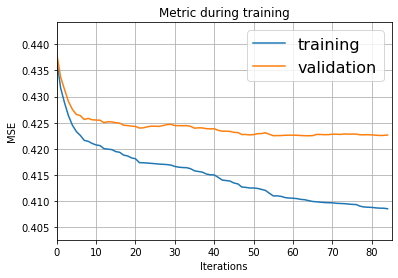

mae is : 0.42123431316018706
sae is : 0.00018941880763370696
nde of this model is: 0.2817013218775211
[1]	training's l2: 48882.8	training's l1: 55.0266	validation's l2: 49457.4	validation's l1: 55.2837
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 31989	training's l1: 43.8768	validation's l2: 32818.6	validation's l1: 44.2896
[3]	training's l2: 22038.7	training's l1: 35.3865	validation's l2: 23061.2	validation's l1: 35.9528
[4]	training's l2: 16028.4	training's l1: 28.8083	validation's l2: 17161.9	validation's l1: 29.5048
[5]	training's l2: 12358.5	training's l1: 23.7172	validation's l2: 13585.4	validation's l1: 24.5139
[6]	training's l2: 10117	training's l1: 19.8239	validation's l2: 11200.7	validation's l1: 20.5614
[7]	training's l2: 8665.37	training's l1: 16.7408	validation's l2: 9733.17	validation's l1: 17.4776
[8]	training's l2: 7803.37	training's l1: 14.3984	validation's l2: 8871.67	validation's l1: 15.1378
[9]	training's l2: 7221.5	training's l1: 

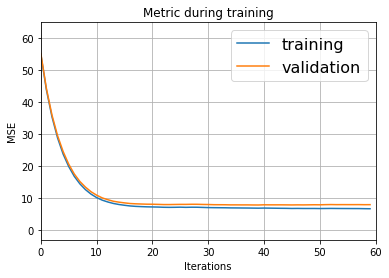

mae is : 6.901868402544431
sae is : 0.004702855385583134
nde of this model is: 0.258348476459223
[1]	training's l2: 54809.4	training's l1: 51.3073	validation's l2: 55348.5	validation's l1: 51.4143
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 36319.1	training's l1: 41.12	validation's l2: 37003.7	validation's l1: 41.2223
[3]	training's l2: 25340.5	training's l1: 33.3452	validation's l2: 25872.6	validation's l1: 33.3291
[4]	training's l2: 18679.2	training's l1: 27.3337	validation's l2: 18994.9	validation's l1: 27.231
[5]	training's l2: 14708.5	training's l1: 22.7084	validation's l2: 14936	validation's l1: 22.5824
[6]	training's l2: 12100.9	training's l1: 19.0748	validation's l2: 12141.3	validation's l1: 18.8609
[7]	training's l2: 10594.7	training's l1: 16.3352	validation's l2: 10513.9	validation's l1: 16.0837
[8]	training's l2: 9633.28	training's l1: 14.192	validation's l2: 9410.27	validation's l1: 13.8596
[9]	training's l2: 9004.88	training's l1: 12.525

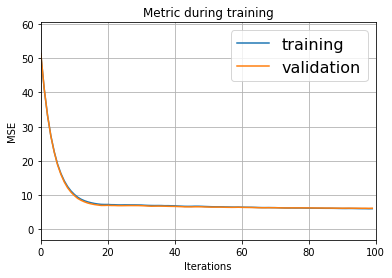

mae is : 6.454215522905866
sae is : 0.022129655635936257
nde of this model is: 0.27494818856660747
mae is : 4.902052713545653
sae is : 0.012620182460714542
nde of this model is: 0.2670621778772538


In [93]:
booster1=lgbbest_train(x_train1,y_train1)
prediction1=booster1.predict(x_test1)
# mae=mean_absolute_error(y_test1, prediction)
prediction1=np.float64(prediction1)
y_test1=np.float64(y_test1)
score(y_test1, prediction1)

booster2=lgbbest_train(x_train2,y_train2)
prediction2=booster2.predict(x_test2)
prediction2=np.float64(prediction2)
y_test2=np.float64(y_test2)
score(y_test2, prediction2)

booster3=lgbbest_train(x_train3,y_train3)
prediction3=booster3.predict(x_test3)
prediction3=np.float64(prediction3)
y_test3=np.float64(y_test3)
score(y_test3, prediction3)

prediction=np.concatenate([prediction1, prediction2, prediction3],axis=0)
y_predict=np.concatenate([y_test1,y_test2,y_test3],axis=0)
score(y_predict,prediction)

In [78]:
model0='F:/NILM/BuildSYS/REDD_dask/washingmachine.pkl'
with open(model0, 'rb+') as f:
    booster0= pickle.load(f)
prediction=booster0.predict(x_predict)
prediction=np.float64(prediction)
y_predict=np.float64(y_predict)
score(y_predict, prediction)

mae is : 2.386958357251079
sae is : 0.004067872287562427
nde of this model is: 0.14764056399732592


In [159]:
model0='F:/NILM/BuildSYS/REDD_dask/washingmachine.pkl'
with open(model0, 'rb+') as f:
    booster0= pickle.load(f)
prediction1=booster0.predict(x_test1)
# mae=mean_absolute_error(y_test1, prediction)
prediction1=np.float64(prediction1)
y_test1=np.float64(y_test1)
score(y_test1, prediction1)

prediction2=booster0.predict(x_test2)
prediction2=np.float64(prediction2)
y_test2=np.float64(y_test2)
score(y_test2, prediction2)


prediction3=booster0.predict(x_test3)
prediction3=np.float64(prediction3)
y_test3=np.float64(y_test3)
score(y_test3, prediction3)

mae is : 0.7784555279081989
sae is : 0.2770907924465149
nde of this model is: 0.48992788281727007
mae is : 3.1107068448414728
sae is : 0.0022742516098473507
nde of this model is: 0.1329362341096101
mae is : 2.9386845425551797
sae is : 0.026742862547140506
nde of this model is: 0.16012200438719632


[1]	training's l2: 44163.3	training's l1: 41.4535	validation's l2: 48114	validation's l1: 43.074
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 33873.8	training's l1: 36.2443	validation's l2: 36969.1	validation's l1: 37.676
[3]	training's l2: 26115.2	training's l1: 31.7212	validation's l2: 28571.3	validation's l1: 32.9935
[4]	training's l2: 20260	training's l1: 27.7996	validation's l2: 22188.6	validation's l1: 28.9155
[5]	training's l2: 15838.6	training's l1: 24.3981	validation's l2: 17384.5	validation's l1: 25.3862
[6]	training's l2: 12460.4	training's l1: 21.4261	validation's l2: 13719.6	validation's l1: 22.3109
[7]	training's l2: 9940.2	training's l1: 18.8681	validation's l2: 10971.6	validation's l1: 19.6584
[8]	training's l2: 7987.8	training's l1: 16.6326	validation's l2: 8843.35	validation's l1: 17.3479
[9]	training's l2: 6533.85	training's l1: 14.7065	validation's l2: 7258.79	validation's l1: 15.3532
[10]	training's l2: 5444.41	training's l1: 13.0

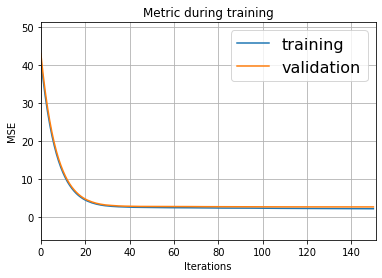

mae is : 2.664477458515372
sae is : 0.00511320138700668
nde of this model is: 0.1549449427690515


In [144]:
booster=lgbbest_train1(x_train,y_train)
prediction=booster.predict(x_predict)
prediction=np.float64(prediction)
y_predict=np.float64(y_predict)
score(y_predict, prediction)

In [160]:
trainfile1 = "F:/NILM/training_data/microwave_house_2_training_.csv"
trainfile2 = "F:/NILM/training_data/microwave_house_3_training_.csv"
testfile="F:/NILM/training_data/microwave_test_.csv"
data_frame1 = pd.read_csv(trainfile1,
                             #chunksize=10 ** 3,
                             header=0
                             )
data_frame2 = pd.read_csv(trainfile2,
                             #chunksize=10 ** 3,
                             header=0
                             )
data_frame3 = pd.read_csv(testfile,
                             #chunksize=10 ** 3,
                             header=0
                             )
x_train1, y_train1, x_test1,  y_test1,x_predict1, y_predict1=EMDpreprocess(data_frame1)
x_train2, y_train2, x_test2,  y_test2,x_predict2, y_predict2=EMDpreprocess(data_frame2)
x_train3, y_train3, x_test3,  y_test3,x_predict3, y_predict3=EMDpreprocess(data_frame3)
x_train=np.concatenate((x_train1,x_train2,x_train3), axis=0)
y_train=np.concatenate((y_train1,y_train2,y_train3), axis=0)
x_predict=np.concatenate((x_test1,x_test2,x_test3), axis=0)
y_predict=np.concatenate((y_test1,y_test2,y_test3), axis=0)

[1]	training's l2: 9548.43	training's l1: 17.5691	validation's l2: 9282.64	validation's l1: 17.5863
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 7718.94	training's l1: 15.7082	validation's l2: 7603.03	validation's l1: 15.8535
[3]	training's l2: 6633.17	training's l1: 14.2552	validation's l2: 6741.56	validation's l1: 14.5203
[4]	training's l2: 5979.93	training's l1: 13.1395	validation's l2: 6135.55	validation's l1: 13.4712
[5]	training's l2: 5436.93	training's l1: 12.1672	validation's l2: 5700.7	validation's l1: 12.5736
[6]	training's l2: 5121.74	training's l1: 11.5062	validation's l2: 5447.48	validation's l1: 11.9396
[7]	training's l2: 4901.56	training's l1: 10.9478	validation's l2: 5282.51	validation's l1: 11.4369
[8]	training's l2: 4712.08	training's l1: 10.4369	validation's l2: 5138.19	validation's l1: 10.9705
[9]	training's l2: 4601.76	training's l1: 10.0894	validation's l2: 5048.58	validation's l1: 10.6513
[10]	training's l2: 4500.7	training's l1

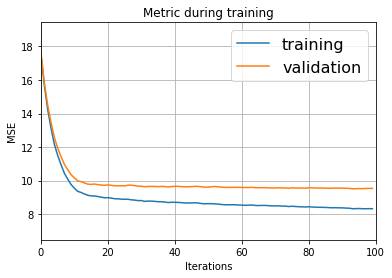

mae is : 8.81471732021906
sae is : 0.009962156467363911
nde of this model is: 0.6071756653275177
[1]	training's l2: 8788.46	training's l1: 11.7689	validation's l2: 8666.11	validation's l1: 11.6379
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 7981.61	training's l1: 11.0396	validation's l2: 7882.33	validation's l1: 10.9028
[3]	training's l2: 7456.45	training's l1: 10.4687	validation's l2: 7387.06	validation's l1: 10.3342
[4]	training's l2: 7076.7	training's l1: 10.005	validation's l2: 7049.2	validation's l1: 9.8863
[5]	training's l2: 6808.77	training's l1: 9.63427	validation's l2: 6837.48	validation's l1: 9.53183
[6]	training's l2: 6604.2	training's l1: 9.35903	validation's l2: 6667.55	validation's l1: 9.27663
[7]	training's l2: 6470.41	training's l1: 9.11386	validation's l2: 6551.88	validation's l1: 9.02677
[8]	training's l2: 6352.12	training's l1: 8.93967	validation's l2: 6455.76	validation's l1: 8.85577
[9]	training's l2: 6215.2	training's l1: 8.8662

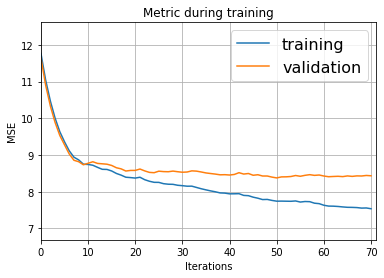

mae is : 8.402347378201473
sae is : 0.04947284345311794
nde of this model is: 0.7035264310089583
[1]	training's l2: 19684	training's l1: 30.5056	validation's l2: 20107.8	validation's l1: 30.5693
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 15840.6	training's l1: 26.7369	validation's l2: 16361.4	validation's l1: 26.9047
[3]	training's l2: 13572.5	training's l1: 23.8857	validation's l2: 14225.4	validation's l1: 24.1544
[4]	training's l2: 12080.8	training's l1: 21.5913	validation's l2: 12739.9	validation's l1: 21.8755
[5]	training's l2: 11114.8	training's l1: 19.7818	validation's l2: 11840.2	validation's l1: 20.0932
[6]	training's l2: 10499.2	training's l1: 18.4039	validation's l2: 11302.9	validation's l1: 18.7649
[7]	training's l2: 10094.1	training's l1: 17.3433	validation's l2: 10917.5	validation's l1: 17.72
[8]	training's l2: 9739.93	training's l1: 16.443	validation's l2: 10631.5	validation's l1: 16.8713
[9]	training's l2: 9457.64	training's l1: 15.73

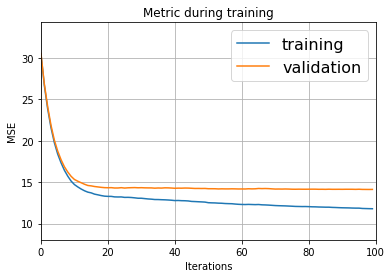

mae is : 14.668433278067903
sae is : 0.013429177339933426
nde of this model is: 0.5872296483173146
mae is : 10.845420528610342
sae is : 0.019348869326090194
nde of this model is: 0.617439817671245


In [95]:
booster1=lgbbest_train(x_train1,y_train1)
prediction1=booster1.predict(x_test1)
# mae=mean_absolute_error(y_test1, prediction)
prediction1=np.float64(prediction1)
y_test1=np.float64(y_test1)
score(y_test1, prediction1)

booster2=lgbbest_train(x_train2,y_train2)
prediction2=booster2.predict(x_test2)
prediction2=np.float64(prediction2)
y_test2=np.float64(y_test2)
score(y_test2, prediction2)

booster3=lgbbest_train(x_train3,y_train3)
prediction3=booster3.predict(x_test3)
prediction3=np.float64(prediction3)
y_test3=np.float64(y_test3)
score(y_test3, prediction3)

prediction=np.concatenate([prediction1, prediction2, prediction3],axis=0)
y_predict=np.concatenate([y_test1,y_test2,y_test3],axis=0)
score(y_predict,prediction)

In [82]:
model0='F:/NILM/BuildSYS/REDD_dask/microwave.pkl'
with open(model0, 'rb+') as f:
    booster0= pickle.load(f)
prediction=booster0.predict(x_predict)
prediction=np.float64(prediction)
y_predict=np.float64(y_predict)
score(y_predict, prediction)

mae is : 7.750225299266042
sae is : 0.00846579948096693
nde of this model is: 0.4118782729332609


In [161]:
model0='F:/NILM/BuildSYS/REDD_dask/microwave.pkl'
with open(model0, 'rb+') as f:
    booster0= pickle.load(f)
prediction1=booster0.predict(x_test1)
# mae=mean_absolute_error(y_test1, prediction)
prediction1=np.float64(prediction1)
y_test1=np.float64(y_test1)
score(y_test1, prediction1)

prediction2=booster0.predict(x_test2)
prediction2=np.float64(prediction2)
y_test2=np.float64(y_test2)
score(y_test2, prediction2)


prediction3=booster0.predict(x_test3)
prediction3=np.float64(prediction3)
y_test3=np.float64(y_test3)
score(y_test3, prediction3)

mae is : 5.359316522830636
sae is : 0.2365333354815914
nde of this model is: 0.31835172055870437
mae is : 8.14199254429445
sae is : 0.4700930833403909
nde of this model is: 0.5129374793112154
mae is : 9.20741392506007
sae is : 0.06448203754665632
nde of this model is: 0.3961807738221073


[1]	training's l2: 14068.5	training's l1: 21.3531	validation's l2: 14701.4	validation's l1: 21.7235
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 12182.1	training's l1: 19.8617	validation's l2: 12827.4	validation's l1: 20.2618
[3]	training's l2: 10709.6	training's l1: 18.5366	validation's l2: 11377.2	validation's l1: 18.9652
[4]	training's l2: 9572.63	training's l1: 17.3762	validation's l2: 10306.5	validation's l1: 17.8431
[5]	training's l2: 8647.63	training's l1: 16.3478	validation's l2: 9457.44	validation's l1: 16.8781
[6]	training's l2: 7934.64	training's l1: 15.4493	validation's l2: 8765.5	validation's l1: 16.0098
[7]	training's l2: 7360.9	training's l1: 14.6663	validation's l2: 8229.78	validation's l1: 15.2601
[8]	training's l2: 6909.47	training's l1: 13.9747	validation's l2: 7828.01	validation's l1: 14.6172
[9]	training's l2: 6536.08	training's l1: 13.3719	validation's l2: 7493.36	validation's l1: 14.0557
[10]	training's l2: 6231.24	training's l1

[162]	training's l2: 2042.24	training's l1: 7.12309	validation's l2: 4441.91	validation's l1: 9.50666
[163]	training's l2: 2038.04	training's l1: 7.11602	validation's l2: 4439.92	validation's l1: 9.50414
[164]	training's l2: 2031.29	training's l1: 7.10707	validation's l2: 4436.12	validation's l1: 9.49904
[165]	training's l2: 2028.64	training's l1: 7.10328	validation's l2: 4435.89	validation's l1: 9.50109
[166]	training's l2: 2020.21	training's l1: 7.09251	validation's l2: 4429.67	validation's l1: 9.49915
[167]	training's l2: 2015.82	training's l1: 7.09437	validation's l2: 4432.52	validation's l1: 9.50763
[168]	training's l2: 2008.01	training's l1: 7.08587	validation's l2: 4427.83	validation's l1: 9.50372
[169]	training's l2: 2004.34	training's l1: 7.08118	validation's l2: 4428.55	validation's l1: 9.50492
[170]	training's l2: 2001.7	training's l1: 7.07785	validation's l2: 4425.53	validation's l1: 9.50447
[171]	training's l2: 1998.37	training's l1: 7.07317	validation's l2: 4427.48	valida

[322]	training's l2: 1394.03	training's l1: 6.32174	validation's l2: 4090.26	validation's l1: 9.34554
[323]	training's l2: 1389.3	training's l1: 6.31592	validation's l2: 4087.44	validation's l1: 9.3404
[324]	training's l2: 1386.83	training's l1: 6.31168	validation's l2: 4082.84	validation's l1: 9.33654
[325]	training's l2: 1381.18	training's l1: 6.30348	validation's l2: 4080.71	validation's l1: 9.33599
[326]	training's l2: 1379.5	training's l1: 6.30134	validation's l2: 4079.16	validation's l1: 9.3353
[327]	training's l2: 1376.96	training's l1: 6.29554	validation's l2: 4077.13	validation's l1: 9.33253
[328]	training's l2: 1374.12	training's l1: 6.29124	validation's l2: 4075.71	validation's l1: 9.33205
[329]	training's l2: 1370.32	training's l1: 6.28408	validation's l2: 4075.92	validation's l1: 9.33288
[330]	training's l2: 1366.19	training's l1: 6.27672	validation's l2: 4073.76	validation's l1: 9.32838
[331]	training's l2: 1363.6	training's l1: 6.27351	validation's l2: 4070.31	validation

[482]	training's l2: 1032.88	training's l1: 5.74597	validation's l2: 3879.99	validation's l1: 9.19656
[483]	training's l2: 1030.43	training's l1: 5.73954	validation's l2: 3879.53	validation's l1: 9.1949
[484]	training's l2: 1029.23	training's l1: 5.73765	validation's l2: 3876.96	validation's l1: 9.19232
[485]	training's l2: 1027.27	training's l1: 5.73407	validation's l2: 3875.08	validation's l1: 9.19055
[486]	training's l2: 1025.14	training's l1: 5.73006	validation's l2: 3874.6	validation's l1: 9.18996
[487]	training's l2: 1021.98	training's l1: 5.72326	validation's l2: 3874.59	validation's l1: 9.18968
[488]	training's l2: 1021.13	training's l1: 5.72199	validation's l2: 3875.08	validation's l1: 9.19012
[489]	training's l2: 1019.62	training's l1: 5.71973	validation's l2: 3873.66	validation's l1: 9.18958
[490]	training's l2: 1019.03	training's l1: 5.71801	validation's l2: 3875.22	validation's l1: 9.19021
[491]	training's l2: 1016.85	training's l1: 5.7151	validation's l2: 3874.49	validati

[642]	training's l2: 852.821	training's l1: 5.40102	validation's l2: 3785.49	validation's l1: 9.13325
[643]	training's l2: 852.41	training's l1: 5.40048	validation's l2: 3785.06	validation's l1: 9.13324
[644]	training's l2: 851.339	training's l1: 5.39817	validation's l2: 3783.8	validation's l1: 9.13307
[645]	training's l2: 849.768	training's l1: 5.39513	validation's l2: 3782.81	validation's l1: 9.13175
[646]	training's l2: 849.455	training's l1: 5.39473	validation's l2: 3783.03	validation's l1: 9.1317
[647]	training's l2: 848.382	training's l1: 5.39216	validation's l2: 3783.44	validation's l1: 9.13204
[648]	training's l2: 846.894	training's l1: 5.38965	validation's l2: 3783.45	validation's l1: 9.13107
[649]	training's l2: 846.202	training's l1: 5.38811	validation's l2: 3782.56	validation's l1: 9.13053
[650]	training's l2: 845.699	training's l1: 5.38728	validation's l2: 3782.17	validation's l1: 9.13086
[651]	training's l2: 844.499	training's l1: 5.38393	validation's l2: 3780.3	validatio

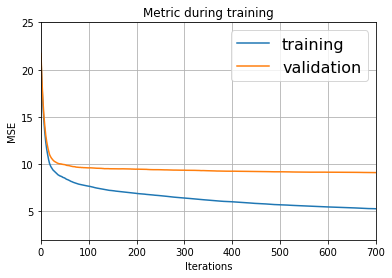

mae is : 9.018715518324411
sae is : 0.013982214649921911
nde of this model is: 0.4598494861087381


In [146]:
booster=lgbbest_train1(x_train,y_train)
prediction=booster.predict(x_predict)
prediction=np.float64(prediction)
y_predict=np.float64(y_predict)
score(y_predict, prediction)

In [42]:
dtrain1 = lgb.Dataset(x_train1, y_train1)
dtest1 = lgb.Dataset(x_test1, y_test1)
params = {
        'boosting': 'dart',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'num_leaves': 1000,
        # 'num_leaves': 2,
        'min_data_in_leaf': 200,
        'max_depth': 10,
        'learning_rate': 0.23179,
        # 'feature_fraction':argsDict['feature_fraction'],
        # 'bagging_fraction': argsDict['bagging_fraction'],
        # 'bagging_freq': argsDict['bagging_freq'],
        'max_bin':500,
        # 'num_boost_round':argsDict['num_boost_rount'] ,
        'min_data_in_bin': 100,
        'lambda_l2': 0,
        'lambda_l1': 0.7145,
        'verbose': -1,
        'is_provide_training_metric': True,
        # 'bin_construct_sample_cnt': 59139
}
gbm1 = lgb.train(params, dtrain1, num_boost_round=50, valid_sets=dtest1, early_stopping_rounds=10)

[1]	valid_0's l2: 6678.45	valid_0's l1: 15.147
[2]	valid_0's l2: 4812.58	valid_0's l1: 12.9402
[3]	valid_0's l2: 3647.85	valid_0's l1: 11.2385
[4]	valid_0's l2: 2935.72	valid_0's l1: 9.92434
[5]	valid_0's l2: 2434.76	valid_0's l1: 8.78986
[6]	valid_0's l2: 2097.62	valid_0's l1: 7.92817
[7]	valid_0's l2: 1895.47	valid_0's l1: 7.2853
[8]	valid_0's l2: 2061.57	valid_0's l1: 7.89124
[9]	valid_0's l2: 1851.44	valid_0's l1: 7.24959
[10]	valid_0's l2: 1675.39	valid_0's l1: 6.65447
[11]	valid_0's l2: 1571.08	valid_0's l1: 6.23988
[12]	valid_0's l2: 1627.38	valid_0's l1: 6.50342
[13]	valid_0's l2: 1545.29	valid_0's l1: 6.11326
[14]	valid_0's l2: 1492.79	valid_0's l1: 5.82053
[15]	valid_0's l2: 1443.31	valid_0's l1: 5.58203
[16]	valid_0's l2: 1404.42	valid_0's l1: 5.376
[17]	valid_0's l2: 1369.65	valid_0's l1: 5.21868
[18]	valid_0's l2: 1345.73	valid_0's l1: 5.0979
[19]	valid_0's l2: 1331.96	valid_0's l1: 5.01807
[20]	valid_0's l2: 1321.33	valid_0's l1: 4.99293
[21]	valid_0's l2: 1327.37	valid_0

In [43]:
dtrain2 = lgb.Dataset(x_train2, y_train2)
dtest2 = lgb.Dataset(x_test2, y_test2)
params = {
        'boosting': 'dart',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'num_leaves': 1000,
        # 'num_leaves': 2,
        'min_data_in_leaf': 200,
        'max_depth': 10,
        'learning_rate': 0.23179,
        # 'feature_fraction':argsDict['feature_fraction'],
        # 'bagging_fraction': argsDict['bagging_fraction'],
        # 'bagging_freq': argsDict['bagging_freq'],
        'max_bin':500,
        # 'num_boost_round':argsDict['num_boost_rount'] ,
        'min_data_in_bin': 100,
        'lambda_l2': 0,
        'lambda_l1': 0.7145,
        'verbose': -1,
        'is_provide_training_metric': True,
        # 'bin_construct_sample_cnt': 59139
}
gbm2 = lgb.train(params, dtrain2, num_boost_round=50, valid_sets=dtest2, early_stopping_rounds=10)

[1]	valid_0's l2: 3652.45	valid_0's l1: 11.8526
[2]	valid_0's l2: 3238.59	valid_0's l1: 11.0405
[3]	valid_0's l2: 2947.91	valid_0's l1: 10.3909
[4]	valid_0's l2: 2750.55	valid_0's l1: 9.90581
[5]	valid_0's l2: 2586.77	valid_0's l1: 9.50396
[6]	valid_0's l2: 2466.97	valid_0's l1: 9.18507
[7]	valid_0's l2: 2384.06	valid_0's l1: 8.97679
[8]	valid_0's l2: 2428.9	valid_0's l1: 9.16889
[9]	valid_0's l2: 2352.49	valid_0's l1: 8.91171
[10]	valid_0's l2: 2291.29	valid_0's l1: 8.73368
[11]	valid_0's l2: 2248.14	valid_0's l1: 8.58982
[12]	valid_0's l2: 2268.43	valid_0's l1: 8.65877
[13]	valid_0's l2: 2234.82	valid_0's l1: 8.51413
[14]	valid_0's l2: 2193.84	valid_0's l1: 8.40007
[15]	valid_0's l2: 2166.42	valid_0's l1: 8.33202
[16]	valid_0's l2: 2142.43	valid_0's l1: 8.27623
[17]	valid_0's l2: 2113.69	valid_0's l1: 8.21515
[18]	valid_0's l2: 2100.84	valid_0's l1: 8.20938
[19]	valid_0's l2: 2083.23	valid_0's l1: 8.20045
[20]	valid_0's l2: 2057.08	valid_0's l1: 8.14511
[21]	valid_0's l2: 2064.02	val

In [45]:
dtrain3 = lgb.Dataset(x_train3, y_train3)
dtest3 = lgb.Dataset(x_test3, y_test3)
params = {
        'boosting': 'dart',
        'objective': 'regression',
        'metric': {'l1', 'l2'},
        'num_leaves': 1000,
        # 'num_leaves': 2,
        'min_data_in_leaf': 200,
        'max_depth': 10,
        'learning_rate': 0.23179,
        # 'feature_fraction':argsDict['feature_fraction'],
        # 'bagging_fraction': argsDict['bagging_fraction'],
        # 'bagging_freq': argsDict['bagging_freq'],
        'max_bin':500,
        # 'num_boost_round':argsDict['num_boost_rount'] ,
        'min_data_in_bin': 100,
        'lambda_l2': 0,
        'lambda_l1': 0.7145,
        'verbose': -1,
        'is_provide_training_metric': True,
        # 'bin_construct_sample_cnt': 59139
}
gbm3 = lgb.train(params, dtrain3, num_boost_round=50, valid_sets=dtest3, early_stopping_rounds=10)

[1]	valid_0's l2: 15243.4	valid_0's l1: 40.4966
[2]	valid_0's l2: 10641	valid_0's l1: 34.1455
[3]	valid_0's l2: 7841.03	valid_0's l1: 29.1249
[4]	valid_0's l2: 6165.92	valid_0's l1: 25.3224
[5]	valid_0's l2: 5154.19	valid_0's l1: 22.352
[6]	valid_0's l2: 4509.69	valid_0's l1: 20.0001
[7]	valid_0's l2: 4136.46	valid_0's l1: 18.207
[8]	valid_0's l2: 4485.78	valid_0's l1: 19.9385
[9]	valid_0's l2: 4092.74	valid_0's l1: 18.1047
[10]	valid_0's l2: 3852.49	valid_0's l1: 16.7346
[11]	valid_0's l2: 3689.12	valid_0's l1: 15.6411
[12]	valid_0's l2: 3779.5	valid_0's l1: 16.3752
[13]	valid_0's l2: 3650.72	valid_0's l1: 15.4029
[14]	valid_0's l2: 3527.85	valid_0's l1: 14.5899
[15]	valid_0's l2: 3448.71	valid_0's l1: 13.9642
[16]	valid_0's l2: 3380.59	valid_0's l1: 13.4521
[17]	valid_0's l2: 3326.05	valid_0's l1: 13.0887
[18]	valid_0's l2: 3295.19	valid_0's l1: 12.811
[19]	valid_0's l2: 3251.61	valid_0's l1: 12.6025
[20]	valid_0's l2: 3220.35	valid_0's l1: 12.4487
[21]	valid_0's l2: 3228.56	valid_0'

In [47]:
def score(y_predict, prediction):
    error=[]
    squarey=[]
    print("mae is :", mean_absolute_error(y_predict, prediction))
    r = y_predict.sum()
    r0 = prediction.sum()
    sae = abs(r0 - r) / r
    print("sae is :", sae)
    for i in range(len(prediction)):
        value=prediction[i]-y_predict[i]
        #dif.append(abs(value))    
        error.append(value*value)
        squarey.append(y_predict[i]*y_predict[i])
        #print(y_predict[i]*y_predict[i])
    de1=sqrt(sum(error)/sum(squarey))
    print("nde of this model is:", de1)  

In [ ]:
booster1=lgbbest_train(x_train1,y_train1)
prediction1=booster1.predict(x_test1)
# mae=mean_absolute_error(y_test1, prediction)
prediction1=np.float64(prediction1)
y_test1=np.float64(y_test1)
score(y_test1, prediction1)

booster2=lgbbest_train(x_train2,y_train2)
prediction2=booster2.predict(x_test2)
prediction2=np.float64(prediction2)
y_test2=np.float64(y_test2)
score(y_test2, prediction2)

booster3=lgbbest_train(x_train3,y_train3)
prediction3=booster3.predict(x_test3)
prediction3=np.float64(prediction3)
y_test3=np.float64(y_test3)
score(y_test3, prediction3)

booster4=lgbbest_train(x_train4,y_train4)
prediction4=booster4.predict(x_test4)
prediction4=np.float64(prediction4)
y_test4=np.float64(y_test4)
score(y_test4, prediction4)

booster5=lgbbest_train(x_train5,y_train5)
prediction5=booster5.predict(x_test5)
prediction5=np.float64(prediction5)
y_test5=np.float64(y_test5)
score(y_test5, prediction5)
prediction=np.concatenate([prediction1, prediction2, prediction3,prediction4, prediction5])
y_predict=np.concatenate([y_test1,y_test2,y_test3,y_test4, y_test5])
score(y_predict,prediction)